In [58]:
# ===============================
# Cell 1 — Imports & Global Config
# ===============================
import os, json, math, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 140
sns.set_context("notebook")

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Paths
DATA_PATH  = "data/housing_adequacy_dataset.csv"

# Split
CUTOFF_DATE = "2018-12-31"  # train ≤ cutoff, test > cutoff

# Available models
ALL_MODELS = ["lr", "rf", "ridge", "xgb", "etr"]  # trim as needed

# ===============================
# Choose prediction target here:
# "next_quarter"            -> H=1
# "same_quarter_next_year"  -> H=4
# ===============================
PREDICTION_CHOICE = "same_quarter_next_year"  # or "next_quarter"


In [59]:
# ===============================
# Cell 2 — Build Modeling Frame (create all needed lags once)
# ===============================
def build_model_frame(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a modeling DataFrame with all lags we'll ever need.
    Required input columns: quarter, province, dwelling_starts, pop_change_q, needed_units_q
    """
    df = df.sort_values(["province", "quarter"]).copy()
    df["quarter"] = pd.PeriodIndex(df["quarter"], freq="Q").to_timestamp()

    # Target
    df["y"] = df["dwelling_starts"]

    # y lags
    for L in [1, 2, 3, 4, 8]:
        df[f"dwelling_starts_lag{L}"] = df.groupby("province")["dwelling_starts"].shift(L)

    # exog lags (match horizons we’ll use)
    for L in [1, 4, 8]:
        for col in ["pop_change_q", "needed_units_q"]:
            df[f"{col}_lag{L}"] = df.groupby("province")[col].shift(L)

    # quarter dummies (safe feature, known at forecast time)
    qdum = pd.get_dummies(df["quarter"].dt.quarter, prefix="q")
    # keep Q2–Q4; Q1 is baseline (optional)
    if "q_1" in qdum:
        qdum = qdum.drop(columns=["q_1"])
    df = pd.concat([df, qdum], axis=1)

    return df


In [60]:
# ===============================
# Cell 3 — Feature selection per horizon
# ===============================
def features_for_choice(choice: str):
    """
    Leak-safe features per prediction choice.
    - next_quarter (H=1): can use lag1 and lag4 exogs
    - same_quarter_next_year (H=4): ONLY lags >=4 (no lag1–3)
    """
    choice = choice.lower()
    if choice == "next_quarter":
        H = 1
        feat_cols = [
            "dwelling_starts_lag1", "dwelling_starts_lag4",
            "pop_change_q_lag1", "needed_units_q_lag1",
            # optional: "q_2","q_3","q_4"
        ]
    elif choice == "same_quarter_next_year":
        H = 4
        feat_cols = [
            "dwelling_starts_lag4", "dwelling_starts_lag8",
            "pop_change_q_lag4", "needed_units_q_lag4",
            # optional: "q_2","q_3","q_4"
        ]
    else:
        raise ValueError("choice must be 'next_quarter' or 'same_quarter_next_year'")
    return H, feat_cols


In [61]:
# ===============================
# Cell 4 — Splits, Metrics, Rolling
# ===============================
def chrono_split(df, cutoff):
    cutoff = pd.Timestamp(cutoff)
    tr = df[df["quarter"] <= cutoff].copy()
    te = df[df["quarter"] >  cutoff].copy()
    return tr, te

def rolling_split(df, initial=None, step=1, fh=1):
    """
    Expanding-window CV over the full panel (all provinces).
    Yields (train_df, test_df) for the next fh quarters (panel slices).
    """
    df = df.copy()
    df["quarter"] = pd.to_datetime(df["quarter"], errors="coerce")
    dates = pd.Index(df["quarter"].dropna().unique()).sort_values()
    if len(dates) == 0:
        return

    if initial is None:
        initial = dates[int(0.6 * len(dates))]
    else:
        initial = pd.Timestamp(initial)

    start_idx = dates.get_indexer([initial], method="ffill")[0]
    start_idx = max(start_idx, 0)

    for i in range(start_idx, len(dates) - fh, step):
        train_end = dates[i]
        test_slice = dates[i+1 : i+1+fh]
        tr = df[df["quarter"] <= train_end].copy()
        te = df[df["quarter"].isin(test_slice)].copy()
        if not te.empty:
            yield tr, te

def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    eps = 1e-8
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps))
    return {"MAE": mae, "RMSE": rmse, "sMAPE": smape}

def _naive_mae_train(y_train: pd.Series, season: int = 1, eps: float = 1e-12) -> float:
    y = y_train.to_numpy()
    if len(y) <= season:
        return np.nan
    denom = np.mean(np.abs(y[season:] - y[:-season]))
    return max(denom, eps)


In [62]:
# ===============================
# Cell 5 — Model factory & param spaces
# ===============================
def make_model(name, **kw):
    if name == "lr":
        model = LinearRegression()
    elif name == "ridge":
        model = Pipeline([("scaler", StandardScaler()), ("est", Ridge())])
    elif name == "lasso":
        model = Pipeline([("scaler", StandardScaler()), ("est", Lasso(max_iter=20000))])
    elif name == "enet":
        model = Pipeline([("scaler", StandardScaler()), ("est", ElasticNet(max_iter=20000))])
    elif name == "rf":
        model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
    elif name == "etr":
        model = ExtraTreesRegressor(n_jobs=-1, random_state=RANDOM_STATE)
    elif name == "gbr":
        model = GradientBoostingRegressor(random_state=RANDOM_STATE)
    elif name == "svr":
        model = Pipeline([("scaler", StandardScaler()), ("est", SVR())])
    elif name == "xgb":
        model = XGBRegressor(
            tree_method="hist",
            n_estimators=400,
            learning_rate=0.05,
            random_state=RANDOM_STATE
        )
    else:
        raise ValueError(f"Unknown model: {name}")
    if kw:
        model.set_params(**kw)
    return model

# conservative param spaces to keep runtime reasonable
PARAM_SPACE = {
    "lr":   {},
    "ridge": {"est__alpha": np.logspace(-2, 2, 9)},
    "lasso": {"est__alpha": np.logspace(-3, 0.5, 8)},
    "enet":  {"est__alpha": np.logspace(-3, 0.5, 6), "est__l1_ratio": [0.2, 0.5, 0.8]},
    "rf":   {"n_estimators": [200, 400], "max_depth": [None, 8], "min_samples_split": [2, 5],
             "min_samples_leaf": [1, 2], "max_features": ["sqrt", 0.8]},
    "etr":  {"n_estimators": [400, 800], "max_depth": [None, 10], "min_samples_split": [2, 5],
             "min_samples_leaf": [1, 2], "max_features": ["sqrt", 0.8]},
    "gbr":  {"n_estimators": [300, 600], "learning_rate": [0.03, 0.1], "max_depth": [2, 3], "subsample": [0.85, 1.0]},
    "svr":  {"est__C": [0.3, 1, 3, 10], "est__epsilon": [0.01, 0.1, 0.3], "est__gamma": ["scale"]},
    "xgb":  {"max_depth": [3, 6], "min_child_weight": [1, 4], "subsample": [0.8, 1.0], "colsample_bytree": [0.8, 1.0]},
}


In [63]:
# ===============================
# Cell 6 — Tuning utilities (expanding-window) + caching per choice
# ===============================
def sample_param_grid(space: dict, n_iter: int, rng: np.random.RandomState):
    if not space:
        return [dict()]
    keys = list(space.keys())
    samples = []
    for _ in range(n_iter):
        d = {}
        for k in keys:
            v = space[k]
            if isinstance(v, (list, tuple, np.ndarray)):
                d[k] = v[rng.randint(0, len(v))]
            else:
                d[k] = v
        samples.append(d)
    return samples

def rolling_score_one_fold(model, tr, te, features, target="dwelling_starts", season=1):
    Xtr, ytr = tr[features], tr[target]
    Xte, yte = te[features], te[target]
    model.fit(Xtr, ytr)
    ypred = model.predict(Xte)
    denom = _naive_mae_train(ytr, season=season)
    mae = mean_absolute_error(yte, ypred)
    return mae / denom

def tune_model_for_province(df, features, model_name, n_iter=20, fh=1, initial=None,
                            target="dwelling_starts", season=1, random_state=RANDOM_STATE):
    space = PARAM_SPACE[model_name]
    rng = np.random.RandomState(random_state)
    candidates = sample_param_grid(space, n_iter=n_iter, rng=rng)

    scores = []
    for params in candidates:
        fold_scores = []
        for tr, te in rolling_split(df, initial=initial, fh=fh):
            m = make_model(model_name, **params)
            try:
                s = rolling_score_one_fold(m, tr, te, features, target=target, season=season)
                if np.isfinite(s):
                    fold_scores.append(s)
            except Exception:
                pass
        score = np.mean(fold_scores) if len(fold_scores) else np.inf
        scores.append((params, score))

    scores.sort(key=lambda x: x[1])
    best_params, best_score = scores[0]
    return best_params, best_score, scores

def tune_all_models_per_province(train_df, features, models_to_run, n_iter=20, fh=1,
                                 initial=None, target="dwelling_starts",
                                 season=1, random_state=RANDOM_STATE):
    best_params = {}
    best_scores = {}

    provinces = list(train_df["province"].unique())
    total_tasks = len(provinces) * len(models_to_run)
    task = 0

    print(f"🧮 Tuning: {len(provinces)} provinces × {len(models_to_run)} models × {n_iter} trials (fh={fh}, season={season})")
    for prov, gtr in train_df.groupby("province"):
        for name in models_to_run:
            task += 1
            print(f"→ [{task}/{total_tasks}] {prov.upper()} — {name.upper()} ...", end=" ", flush=True)
            bp, bs, _ = tune_model_for_province(
                df=gtr, features=features, model_name=name, n_iter=n_iter, fh=fh,
                initial=initial, target=target, season=season, random_state=random_state
            )
            best_params[(prov, name)] = bp
            best_scores[(prov, name)] = bs
            print(f"best MASE={bs:.3f}")
    print("✅ Tuning done.")
    return best_params, best_scores

def cache_path_for_choice(choice: str) -> str:
    return f"best_params_cache_{'h1' if choice=='next_quarter' else 'h4'}.json"

def load_or_tune_best_params(train_df, features, models_to_run,
                             prediction_choice: str,
                             n_iter=10, fh=1, initial=None):
    cache_path = cache_path_for_choice(prediction_choice)
    if os.path.exists(cache_path):
        print(f"🔁 Loading cached best parameters from {cache_path}")
        with open(cache_path, "r") as f:
            best_params = json.load(f)
        best_params = {tuple(k.split("|")): v for k, v in best_params.items()}
        return best_params
    else:
        print("⏳ Running tuning from scratch...")
        season = 1 if prediction_choice == "next_quarter" else 4
        best_params, _ = tune_all_models_per_province(
            train_df=train_df,
            features=features,
            models_to_run=models_to_run,
            n_iter=n_iter,
            fh=fh,
            initial=initial,
            target="dwelling_starts",
            season=season,
            random_state=RANDOM_STATE
        )
        best_params_str = {"|".join(k): v for k, v in best_params.items()}
        with open(cache_path, "w") as f:
            json.dump(best_params_str, f, indent=2)
        print(f"✅ Saved tuned best parameters to {cache_path}")
        return best_params


In [64]:
# ===============================
# Cell 7 — Final fit (TRAIN) with tuned params, predict on TEST
# ===============================
def fit_predict_holdout_per_province(train_df, test_df, features, models_to_run, best_params,
                                     prediction_choice: str, target="dwelling_starts"):
    season = 1 if prediction_choice == "next_quarter" else 4
    rows = []
    for prov, gtr in train_df.groupby("province"):
        gte = test_df[test_df["province"] == prov]
        if gte.empty:
            continue
        for name in models_to_run:
            params = best_params.get((prov, name), {})
            m = make_model(name, **params)
            Xtr, ytr = gtr[features], gtr[target]
            Xte, yte = gte[features], gte[target]
            m.fit(Xtr, ytr)
            ypred = m.predict(Xte)

            res = metrics(yte, ypred)
            denom = _naive_mae_train(ytr, season=season)
            res["MASE"] = res["MAE"] / denom

            for q, yt, yp in zip(gte["quarter"].values, yte.values, ypred):
                rows.append({
                    "province": prov, "model": name,
                    "quarter": pd.to_datetime(q), "y_true": yt, "y_pred": yp,
                    **res
                })
    return pd.DataFrame(rows)

def summarize_metrics_table(preds_df: pd.DataFrame):
    g_model = (preds_df.groupby("model")[["MAE","RMSE","sMAPE","MASE"]]
               .mean().round(2).sort_values("MAE"))
    display(g_model)
    g_pm = (preds_df.groupby(["province","model"])[["MAE","RMSE","sMAPE","MASE"]]
            .mean().round(2))
    return g_model, g_pm


In [82]:
# ===============================
# Cell 8 — Visualizations (holdout overlay + rolling overlays)
# ===============================
def plot_holdout_overlay(preds_df, models_to_run, suptitle="True vs Predicted (Holdout) — Overlaid Models (Tuned)"):
    provs = sorted(preds_df["province"].unique())
    cols = 4
    rows = math.ceil(len(provs) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 2.6*rows), sharex=False, sharey=False)
    axes = axes.ravel()

    for i, prov in enumerate(provs):
        ax = axes[i]
        g = preds_df[preds_df["province"] == prov].copy()
        truth = g.drop_duplicates("quarter")[["quarter","y_true"]].sort_values("quarter")
        ax.plot(truth["quarter"], truth["y_true"], color="black", linewidth=1.8, alpha=.6, label="True")

        for name in models_to_run:
            gm = g[g["model"] == name].sort_values("quarter")
            if gm.empty:
                continue
            ax.plot(gm["quarter"], gm["y_pred"], "--", linewidth=1.5, label=name.upper())

        ax.set_title(prov.upper(), fontsize=10)
        ax.tick_params(axis="x", labelrotation=45)
        ax.grid(True, linestyle="--", alpha=0.3)

    for j in range(i+1, rows*cols):
        fig.delaxes(axes[j])

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=min(2+len(models_to_run), 6),
               frameon=False, bbox_to_anchor=(0.5, -0.02))
    fig.suptitle(suptitle, y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

def rolling_evolution_overlay(df_all, features, best_params, models_to_plot,
                              fh=1, initial=None, target="dwelling_starts",
                              show_history=False, step=1, last_k_cutoffs=None,
                              return_df=False):
    models_to_plot = [m.lower() for m in models_to_plot]
    rows = []
    folds = list(rolling_split(df_all, initial=initial, fh=fh, step=step))
    if last_k_cutoffs is not None and len(folds) > last_k_cutoffs:
        folds = folds[-last_k_cutoffs:]

    for tr, te in folds:
        cutoff = pd.to_datetime(tr["quarter"].max())
        for prov, gtr in tr.groupby("province"):
            gte = te[te["province"] == prov]
            if gte.empty:
                continue
            gtr_ = gtr.dropna(subset=features + [target])
            gte_ = gte.dropna(subset=features + [target])
            if gtr_.empty or gte_.empty:
                continue

            Xtr, ytr = gtr_[features], gtr_[target]
            Xte, yte = gte_[features], gte_[target]

            for name in models_to_plot:
                params = best_params.get((prov, name), {})
                try:
                    m = make_model(name, **params)
                    m.fit(Xtr, ytr)
                    denom = np.mean(np.abs(ytr.diff(fh).dropna()))  # seasonal naive MAE on this fold’s TRAIN
                    yhat = m.predict(Xte)
                    if not np.isfinite(yhat).any():
                        continue
                    rows.append(pd.DataFrame({
                        "cutoff": cutoff,
                        "province": prov,
                        "model": name,
                        "quarter": pd.to_datetime(gte_["quarter"].values),
                        "y_true": yte.values,
                        "y_pred": yhat,
                        "MASE_denom": denom,
                    }))
                except Exception:
                    continue

    if not rows:
        print("No rolling predictions generated — likely all test folds empty after dropna.")
        if return_df:
            return None
        return

    df = pd.concat(rows, ignore_index=True)
    df["quarter"] = pd.to_datetime(df["quarter"])
    df["cutoff"]  = pd.to_datetime(df["cutoff"])
    df = df.sort_values(["province","model","cutoff","quarter"])

    cuts = sorted(df["cutoff"].unique())
    cut_rank = {c:i for i,c in enumerate(cuts)}
    df["cut_rank"] = df["cutoff"].map(cut_rank)

    # ——— Plot (latest only per model) ———
    provs = sorted(df["province"].unique())
    cols = 4
    rows_n = math.ceil(len(provs)/cols)
    fig, axes = plt.subplots(rows_n, cols, figsize=(4*cols, 2.6*rows_n), sharex=False, sharey=False)
    axes = axes.ravel()

    palette = plt.rcParams['axes.prop_cycle'].by_key().get('color', None) or ["C0","C1","C2","C3","C4","C5"]
    model_colors = {m: palette[i % len(palette)] for i, m in enumerate(models_to_plot)}

    for i, prov in enumerate(provs):
        ax = axes[i]
        g = df[df["province"] == prov]
        truth = g.drop_duplicates("quarter")[["quarter","y_true"]].sort_values("quarter")
        ax.plot(truth["quarter"], truth["y_true"], color="black", linewidth=1.6, alpha=.4, label="True")

        for m in models_to_plot:
            gm = g[g["model"] == m]
            if gm.empty:
                continue
            c = model_colors[m]
            if show_history:
                for cu, gc in gm.groupby("cutoff"):
                    if not np.isfinite(gc["y_pred"]).any(): 
                        continue
                    r = cut_rank[cu]
                    alpha = 0.25 + 0.60 * (r / (len(cuts)-1 if len(cuts) > 1 else 1))
                    ax.plot(gc["quarter"], gc["y_pred"], "--", color=c, alpha=alpha, linewidth=1.1)

            latest_cut = gm["cutoff"].max()
            gl = gm[gm["cutoff"] == latest_cut].sort_values("quarter")
            gl = gl[np.isfinite(gl["y_pred"])]
            if not gl.empty:
                ax.plot(gl["quarter"], gl["y_pred"], "--", color=c, linewidth=1.8, label=m.upper())

        ax.set_title(prov.upper(), fontsize=10)
        ax.tick_params(axis="x", labelrotation=45)
        ax.grid(True, linestyle="--", alpha=0.3)

    for j in range(i+1, rows_n*cols):
        fig.delaxes(axes[j])

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=min(2+len(models_to_plot), 6),
               frameon=False, bbox_to_anchor=(0.5, -0.02))
    fig.suptitle("Rolling forecast evolution — overlay by model (latest cutoff)", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

    if return_df:
        return df

def latest_per_quarter(df_preds):
    return (df_preds.sort_values(["province","model","quarter","cutoff"])
                   .drop_duplicates(["province","model","quarter"], keep="last")
                   .sort_values(["province","model","quarter"]))

def rolling_overlay_lines(df_preds, models_to_plot):
    models_to_plot = [m.lower() for m in models_to_plot]
    df = df_preds.copy()
    df["model"] = df["model"].str.lower()

    provs = sorted(df["province"].unique())
    cols = 4
    rows_n = math.ceil(len(provs)/cols)
    fig, axes = plt.subplots(rows_n, cols, figsize=(4*cols, 2.6*rows_n), sharex=False, sharey=False)
    axes = axes.ravel()

    palette = plt.rcParams['axes.prop_cycle'].by_key().get('color', ["C0","C1","C2","C3","C4","C5"])
    model_colors = {m: palette[i % len(palette)] for i, m in enumerate(models_to_plot)}
    model_styles = {m: s for m, s in zip(models_to_plot, ["--","-.",":",(0,(3,1,1,1)),(0,(5,1))])}

    for i, prov in enumerate(provs):
        ax = axes[i]
        g = df[df["province"] == prov]

        truth = g.drop_duplicates("quarter")[["quarter","y_true"]].sort_values("quarter")
        ax.plot(truth["quarter"], truth["y_true"], color="black", lw=1.4, alpha=.45, label="True")

        for m in models_to_plot:
            gl = g[g["model"] == m].sort_values("quarter")
            if gl.empty: 
                continue
            ax.plot(gl["quarter"], gl["y_pred"],
                    linestyle=model_styles[m], color=model_colors[m],
                    marker="o", markersize=2.5, lw=1.6, label=m.upper())

        ax.set_title(prov.upper(), fontsize=10)
        ax.tick_params(axis="x", labelrotation=45)
        ax.grid(True, ls="--", alpha=.3)

    for j in range(i+1, rows_n*cols):
        fig.delaxes(axes[j])

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center",
               ncol=min(2+len(models_to_plot), 6), frameon=False, bbox_to_anchor=(0.5, -0.02))
    fig.suptitle("Rolling forecast — overlay by model (latest prediction per quarter stitched)", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()


In [83]:
# %% [ipython] Add NAIVE (baseline) to holdout + compute metrics (incl. MAPE)
def add_naive_to_holdout(
    safe_df: pd.DataFrame,
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    *,
    horizon: int,                      # 1 (next_quarter) or 4 (same_quarter_next_year)
    target_col: str = "dwelling_starts",
    eps: float = 1e-8
) -> pd.DataFrame:
    """
    Returns a DataFrame matching preds_holdout schema for the naive baseline.
    Columns: ['province','model','quarter','y_true','y_pred','MAE','RMSE','sMAPE','MASE','MAPE']
    """
    # Build naive ŷ_t = y_{t-horizon} within each province
    base = (safe_df[["province", "quarter", target_col]]
            .copy().sort_values(["province","quarter"]))
    base["y_pred"] = base.groupby("province")[target_col].shift(horizon)

    # Keep only the test slice
    out = (test_df[["province","quarter"]]
           .merge(base, on=["province","quarter"], how="left")
           .rename(columns={target_col: "y_true"}))

    # Label and metrics
    out["model"] = "naive"

    # Per-row metrics
    err = out["y_pred"] - out["y_true"]
    out["MAE"]   = err.abs()
    out["RMSE"]  = err**2                           # aggregate later as sqrt(mean)
    out["sMAPE"] = 100 * (2*err.abs() / (out["y_true"].abs() + out["y_pred"].abs() + eps))
    out["MAPE"]  = 100 * (err.abs() / (out["y_true"].abs() + eps))

    # Province-specific MASE denominator from TRAIN (seasonal naive MAE with season=horizon)
    denom = (train_df.groupby("province")[target_col]
                    .apply(lambda s: np.mean(np.abs(s.diff(horizon).dropna())))).to_dict()
    out["MASE"] = out.apply(
        lambda r: (np.abs(r["y_pred"] - r["y_true"]) / max(denom.get(r["province"], np.nan), eps)),
        axis=1
    )

    # Final columns in same order as preds_holdout
    return out[["province","model","quarter","y_true","y_pred","MAE","RMSE","sMAPE","MASE","MAPE"]]


In [84]:
# %% [ipython] Province × Model performance heatmaps (compute metrics from y_true / y_pred)
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_perf_heatmaps_from_preds(
    preds_df: pd.DataFrame,
    metrics=("MASE", "MAE", "RMSE", "sMAPE"),
    *,
    center_on_1=("MASE",),          # metrics to center at 1 (e.g., 'MASE' or any ratio metric)
    aggfunc="mean",                  # 'mean' or 'median' aggregation across test quarters
    annotate=True,
    fmt=".2f",
    cmap_div="coolwarm",
    cmap_seq="viridis",
    figsize_per_panel=(6.0, 5.0),
    ncols=2,
    sort_by="MASE",                  # which computed metric to sort provinces by
    outdir=None,                     # optional save dir
    # ---- MASE options ----
    mase_season_denom_by_province: dict | None = None,
    mase_denom_col: str | None = None,  # column in preds_df with per-row or per-prov denom; if provided, will be used
    mase_fallback_to_existing_col: bool = True,  # if True and no denom supplied, use existing preds_df['MASE'] only for plotting that metric
    smape_scale: float = 100.0,      # sMAPE scaling (100 for percent)
    eps: float = 1e-8,
):
    """
    Build province × model heatmaps for the given metrics, computing them from y_true and y_pred.
    Only 'province', 'model', 'y_true', 'y_pred' are required. (MASE needs a denominator.)

    MASE handling:
      - Preferred: pass `mase_season_denom_by_province` as {province -> denom} (e.g., in-sample seasonal naive MAE).
      - Or pass `mase_denom_col` (a column in preds_df that holds the denom).
      - If neither is given and `mase_fallback_to_existing_col=True`, we'll group the existing 'MASE' column if it exists.
      - Otherwise, 'MASE' will be skipped.
    """
    # --------- checks ---------
    req = {"province", "model", "y_true", "y_pred"}
    missing = req - set(preds_df.columns)
    if missing:
        raise ValueError(f"preds_df must contain {req}; missing: {missing}")

    if isinstance(aggfunc, str):
        aggfunc_callable = {"mean": np.mean, "median": np.median}[aggfunc]
    else:
        aggfunc_callable = aggfunc

    df = preds_df.copy()
    df["model"] = df["model"].str.lower()

    # --------- compute per (province, model) metrics from y_true/y_pred ---------
    def _per_group_metrics(g: pd.DataFrame) -> dict:
        yt = g["y_true"].to_numpy()
        yp = g["y_pred"].to_numpy()
        err = yp - yt
        out = {}

        for m in metrics:
            key = m.upper()

            if key == "MAE":
                out["MAE"] = np.mean(np.abs(err))

            elif key == "RMSE":
                out["RMSE"] = np.sqrt(np.mean(err**2))

            elif key == "SMAPE":
                denom = (np.abs(yt) + np.abs(yp) + eps)
                out["sMAPE"] = smape_scale * np.mean(2.0 * np.abs(err) / denom)

            elif key == "MASE":
                # priority 1: dict mapping province -> denom
                if mase_season_denom_by_province is not None:
                    prov = g["province"].iloc[0]
                    if prov in mase_season_denom_by_province and mase_season_denom_by_province[prov] not in (None, 0):
                        denom = float(mase_season_denom_by_province[prov])
                        out["MASE"] = np.mean(np.abs(err)) / denom
                        continue

                # priority 2: a column in df with the denom
                if mase_denom_col is not None and mase_denom_col in g.columns:
                    denom_vals = g[mase_denom_col].dropna().to_numpy()
                    if denom_vals.size > 0 and np.all(denom_vals > 0):
                        denom = float(np.mean(denom_vals))
                        out["MASE"] = np.mean(np.abs(err)) / denom
                        continue

                # priority 3: fallback to existing 'MASE' column if present and allowed
                if mase_fallback_to_existing_col and "MASE" in g.columns:
                    out["MASE"] = aggfunc_callable(g["MASE"].to_numpy())
                    continue

                # else: skip MASE if we can't compute it
                # (we won't include it in the per-group dict)
                pass

            else:
                # Unknown metric label: try to compute from an existing column if present, else skip
                if m in g.columns:
                    out[m] = aggfunc_callable(g[m].to_numpy())

        return out

    # compute groupwise metrics
    per_g = (df.groupby(["province", "model"], as_index=False)
               .apply(lambda g: pd.Series(_per_group_metrics(g)))
               .reset_index(drop=True))

    # if sort_by requested but couldn't be computed, try fallback to existing column
    if sort_by not in per_g.columns:
        if sort_by in df.columns:
            per_g_sort = (df.groupby(["province", "model"], as_index=False)
                             .agg(**{sort_by: (sort_by, aggfunc_callable)}))
            per_g = per_g.merge(per_g_sort, on=["province","model"], how="left")
        else:
            raise ValueError(f"Cannot sort by '{sort_by}' — metric not computable and not found in preds_df.")

    # province ordering (ascending: better first for error/ratio)
    order_by_prov = (per_g.groupby("province")[sort_by]
                          .mean()
                          .sort_values(ascending=True))
    province_order = order_by_prov.index.tolist()

    model_order = sorted(per_g["model"].unique().tolist())

    # layout
    m = len(metrics)
    ncols = max(1, ncols)
    nrows = math.ceil(m / ncols)
    fw, fh = figsize_per_panel
    fig, axes = plt.subplots(nrows, ncols, figsize=(fw*ncols, fh*nrows), squeeze=False)
    sns.set_style("whitegrid")

    for i, metric in enumerate(metrics):
        r, c = divmod(i, ncols)
        ax = axes[r, c]

        mkey = metric if metric in per_g.columns else metric.upper()
        if mkey not in per_g.columns:
            ax.set_visible(False)
            ax.set_title(f"{metric} (not available)", fontsize=10)
            continue

        pivot = (per_g.pivot(index="province", columns="model", values=mkey)
                       .reindex(index=province_order, columns=model_order))

        if metric.upper() in [x.upper() for x in center_on_1]:
            # center at 1 for baseline-aware metric (e.g., MASE)
            vmin_val = np.nanmin(pivot.values)
            vmax_val = np.nanmax(pivot.values)
            if np.isfinite(vmin_val) and np.isfinite(vmax_val):
                span = max(1 - vmin_val, vmax_val - 1)
                vmin, vmax = 1 - span, 1 + span
            else:
                vmin, vmax = None, None
            sns.heatmap(
                pivot, ax=ax, annot=annotate, fmt=fmt, cmap=cmap_div,
                vmin=vmin, vmax=vmax, center=1.0,
                cbar_kws={"label": metric}
            )
        else:
            sns.heatmap(
                pivot, ax=ax, annot=annotate, fmt=fmt, cmap=cmap_seq,
                cbar_kws={"label": metric}
            )

        ax.set_yticklabels([lab.get_text().upper() for lab in ax.get_yticklabels()], rotation=0)
        ax.set_xlabel("MODEL")
        ax.set_ylabel("PROVINCE")
        ax.set_title(f"{metric} by Province × Model ({aggfunc})", fontsize=11)

        if outdir:
            import os
            os.makedirs(outdir, exist_ok=True)
            fig.savefig(os.path.join(outdir, f"perf_heatmap_{metric.lower()}.png"), bbox_inches="tight")

    # hide unused axes
    total_axes = nrows * ncols
    for j in range(m, total_axes):
        r, c = divmod(j, ncols)
        axes[r, c].set_visible(False)

    fig.tight_layout()
    plt.show()


In [85]:
# %% [ipython] Rank best models across provinces
import numpy as np
import pandas as pd

def rank_models_across_provinces(
    preds_df: pd.DataFrame,
    *,
    metric: str = "MASE",                 # lower is better
    agg: str = "mean",                    # "mean" or "median"
    provinces: list[str] | None = None,   # subset of provinces to include
    models: list[str] | None = None,      # subset of models to include
    min_obs: int = 1,                     # require at least this many test rows per (prov, model)
    tie_breakers: list[str] | None = None,# optional extra metrics (lower-is-better) to break ties
    rank_method: str = "dense",           # pandas rank: "min"/"dense"/"average"/"first"/"max"
    return_tables: bool = True
):
    """
    Compute per-province rankings and an overall leaderboard.

    Returns
    -------
    per_province_rank : DataFrame with columns [province, model, metric_agg, n, rank]
    leaderboard       : DataFrame with overall model summary (wins, avg_rank, med_rank, mean_metric, n_provinces)
    best_by_province  : DataFrame with one row per province = best model
    """
    req_cols = {"province", "model", metric}
    missing = req_cols - set(preds_df.columns)
    if missing:
        raise ValueError(f"preds_df missing required columns: {missing}")

    df = preds_df.copy()
    df["model"] = df["model"].str.lower()

    if provinces is not None:
        df = df[df["province"].isin(provinces)]
    if models is not None:
        models = [m.lower() for m in models]
        df = df[df["model"].isin(models)]

    # aggregate metric within each (province, model)
    if agg not in ("mean", "median"):
        raise ValueError("agg must be 'mean' or 'median'")
    aggfunc = np.mean if agg == "mean" else np.median

    grouped = (df.groupby(["province", "model"], as_index=False)
                 .agg(metric_agg=(metric, aggfunc), n=(metric, "size")))

    # drop combos with insufficient observations
    grouped = grouped[grouped["n"] >= min_obs]
    if grouped.empty:
        raise ValueError("No (province, model) groups remain after filtering by min_obs / subsets.")

    # optional tie-breakers (lower is better for all)
    # we compute same aggregation for them and use in a stable sort per province
    if tie_breakers:
        tb = (df.groupby(["province", "model"], as_index=False)
                .agg(**{f"{m}_agg": (m, aggfunc) for m in tie_breakers if m in df.columns}))
        grouped = grouped.merge(tb, on=["province", "model"], how="left")

    # rank within each province (lower metric_agg is better)
    def _rank_one(g):
        if tie_breakers:
            sort_cols = ["metric_agg"] + [f"{m}_agg" for m in tie_breakers if f"{m}_agg" in g.columns]
        else:
            sort_cols = ["metric_agg"]
        g = g.sort_values(sort_cols, ascending=True, kind="mergesort")  # stable sort
        g["rank"] = g["metric_agg"].rank(method=rank_method, ascending=True)
        return g

    per_province_rank = (grouped.groupby("province", group_keys=False)
                                .apply(_rank_one)
                                .sort_values(["province", "rank", "metric_agg"])
                                .reset_index(drop=True))

    # best model per province (rank == 1)
    best_by_province = (per_province_rank[per_province_rank["rank"] == 1]
                        .sort_values(["metric_agg", "province"])
                        .reset_index(drop=True))

    # overall leaderboard
    leader = (per_province_rank.groupby("model")
              .agg(
                  wins=("rank", lambda s: int((s == 1).sum())),
                  avg_rank=("rank", "mean"),
                  med_rank=("rank", "median"),
                  mean_metric=("metric_agg", "mean"),
                  n_provinces=("province", "nunique")
              )
              .sort_values(["wins", "avg_rank", "mean_metric"], ascending=[False, True, True])
              .reset_index())

    if return_tables:
        # pretty up a bit
        per_province_rank["province"] = per_province_rank["province"].str.upper()
        best_by_province["province"]   = best_by_province["province"].str.upper()
        leader["model"] = leader["model"].str.upper()
        return per_province_rank, leader, best_by_province
    else:
        return None


In [86]:
# Split
CUTOFF_DATE = "2018-12-31"  # train ≤ cutoff, test > cutoff

# Available models
ALL_MODELS = ["lr", "rf", "ridge", "xgb", "etr"]  # trim as needed

# ===============================
# Choose prediction target here:
# "next_quarter"            -> H=1
# "same_quarter_next_year"  -> H=4
# ===============================
PREDICTION_CHOICE = "same_quarter_next_year"  # or "next_quarter"

Mode: same_quarter_next_year | Horizon H=4
Features: ['dwelling_starts_lag4', 'dwelling_starts_lag8', 'pop_change_q_lag4', 'needed_units_q_lag4']
Train: 1992-01-01 → 2018-10-01 | Test: 2019-01-01 → 2025-07-01
🔁 Loading cached best parameters from best_params_cache_h4.json

=== Holdout averages across provinces (tuned) ===


MAE     RMSE  sMAPE  MASE
model                               
lr     1577.84  1991.84  22.15  1.41
ridge  1633.02  2069.92  23.05  1.46
etr    1988.38  2403.20  26.36  1.68
rf     2019.85  2440.83  25.99  1.67
xgb    2021.42  2477.05  27.05  1.71

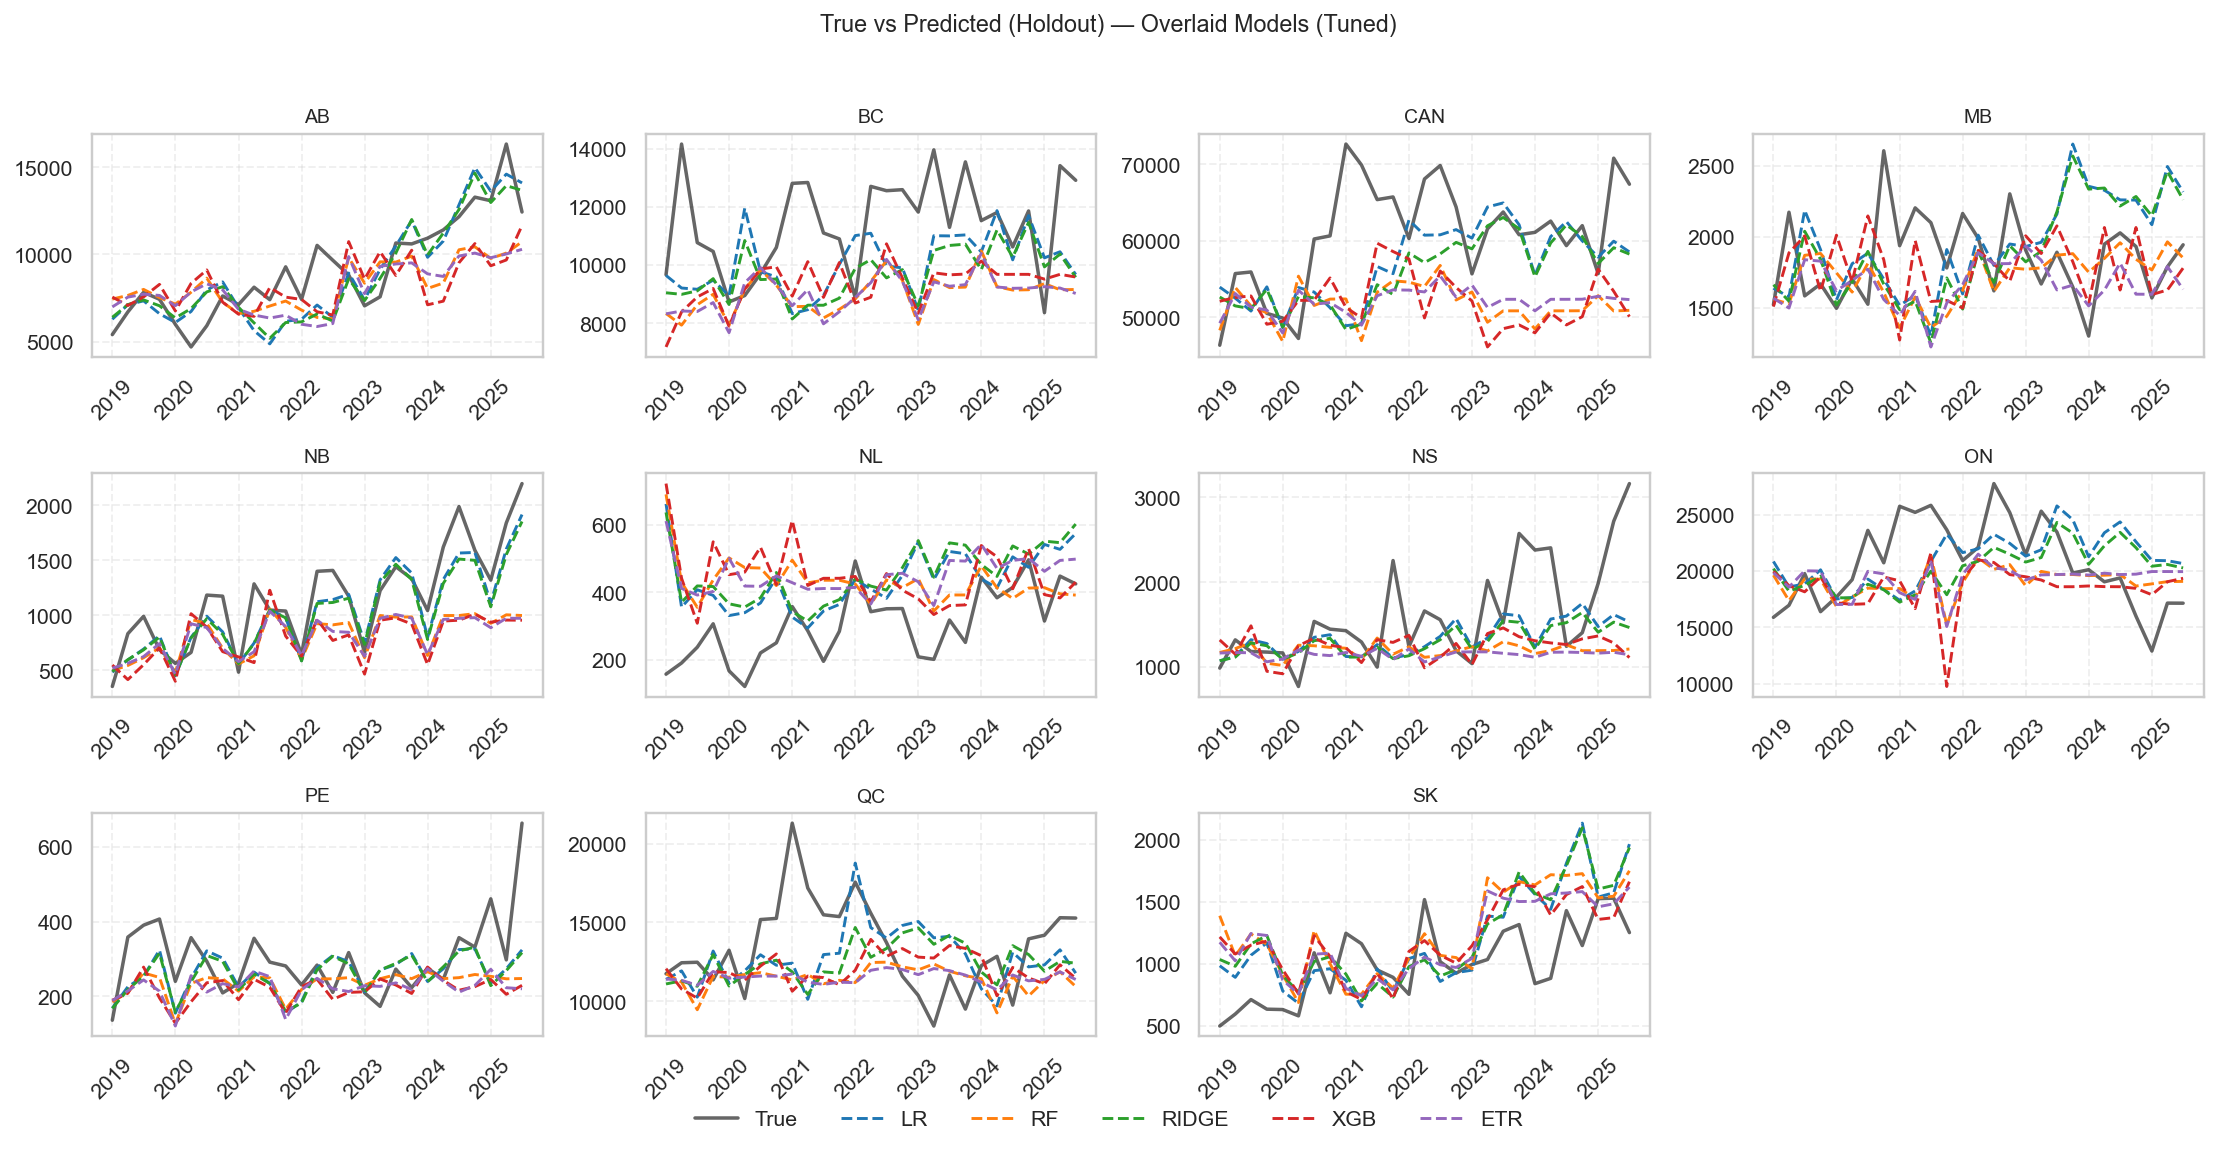

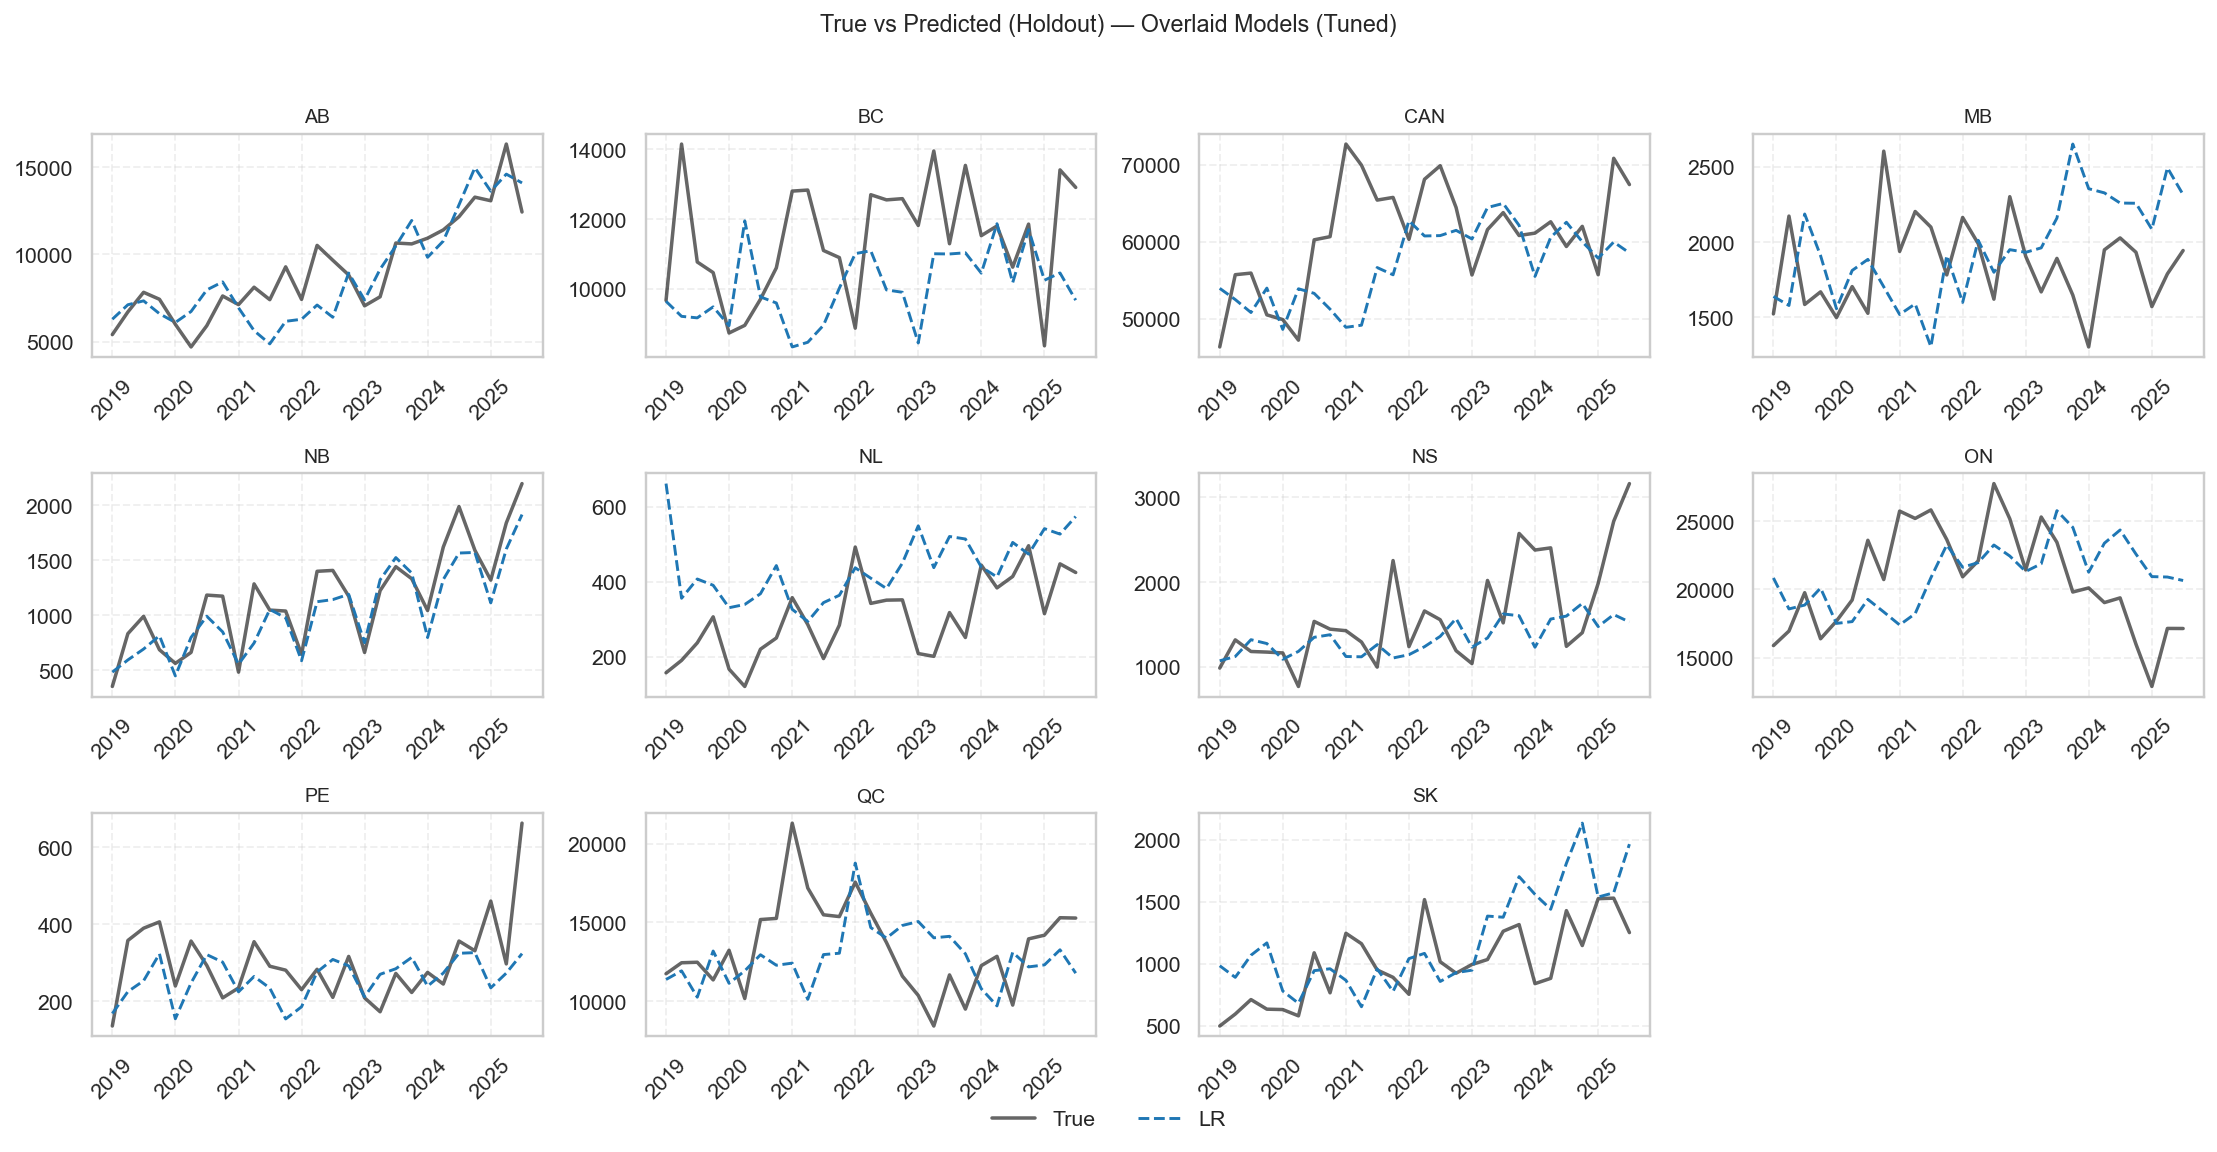

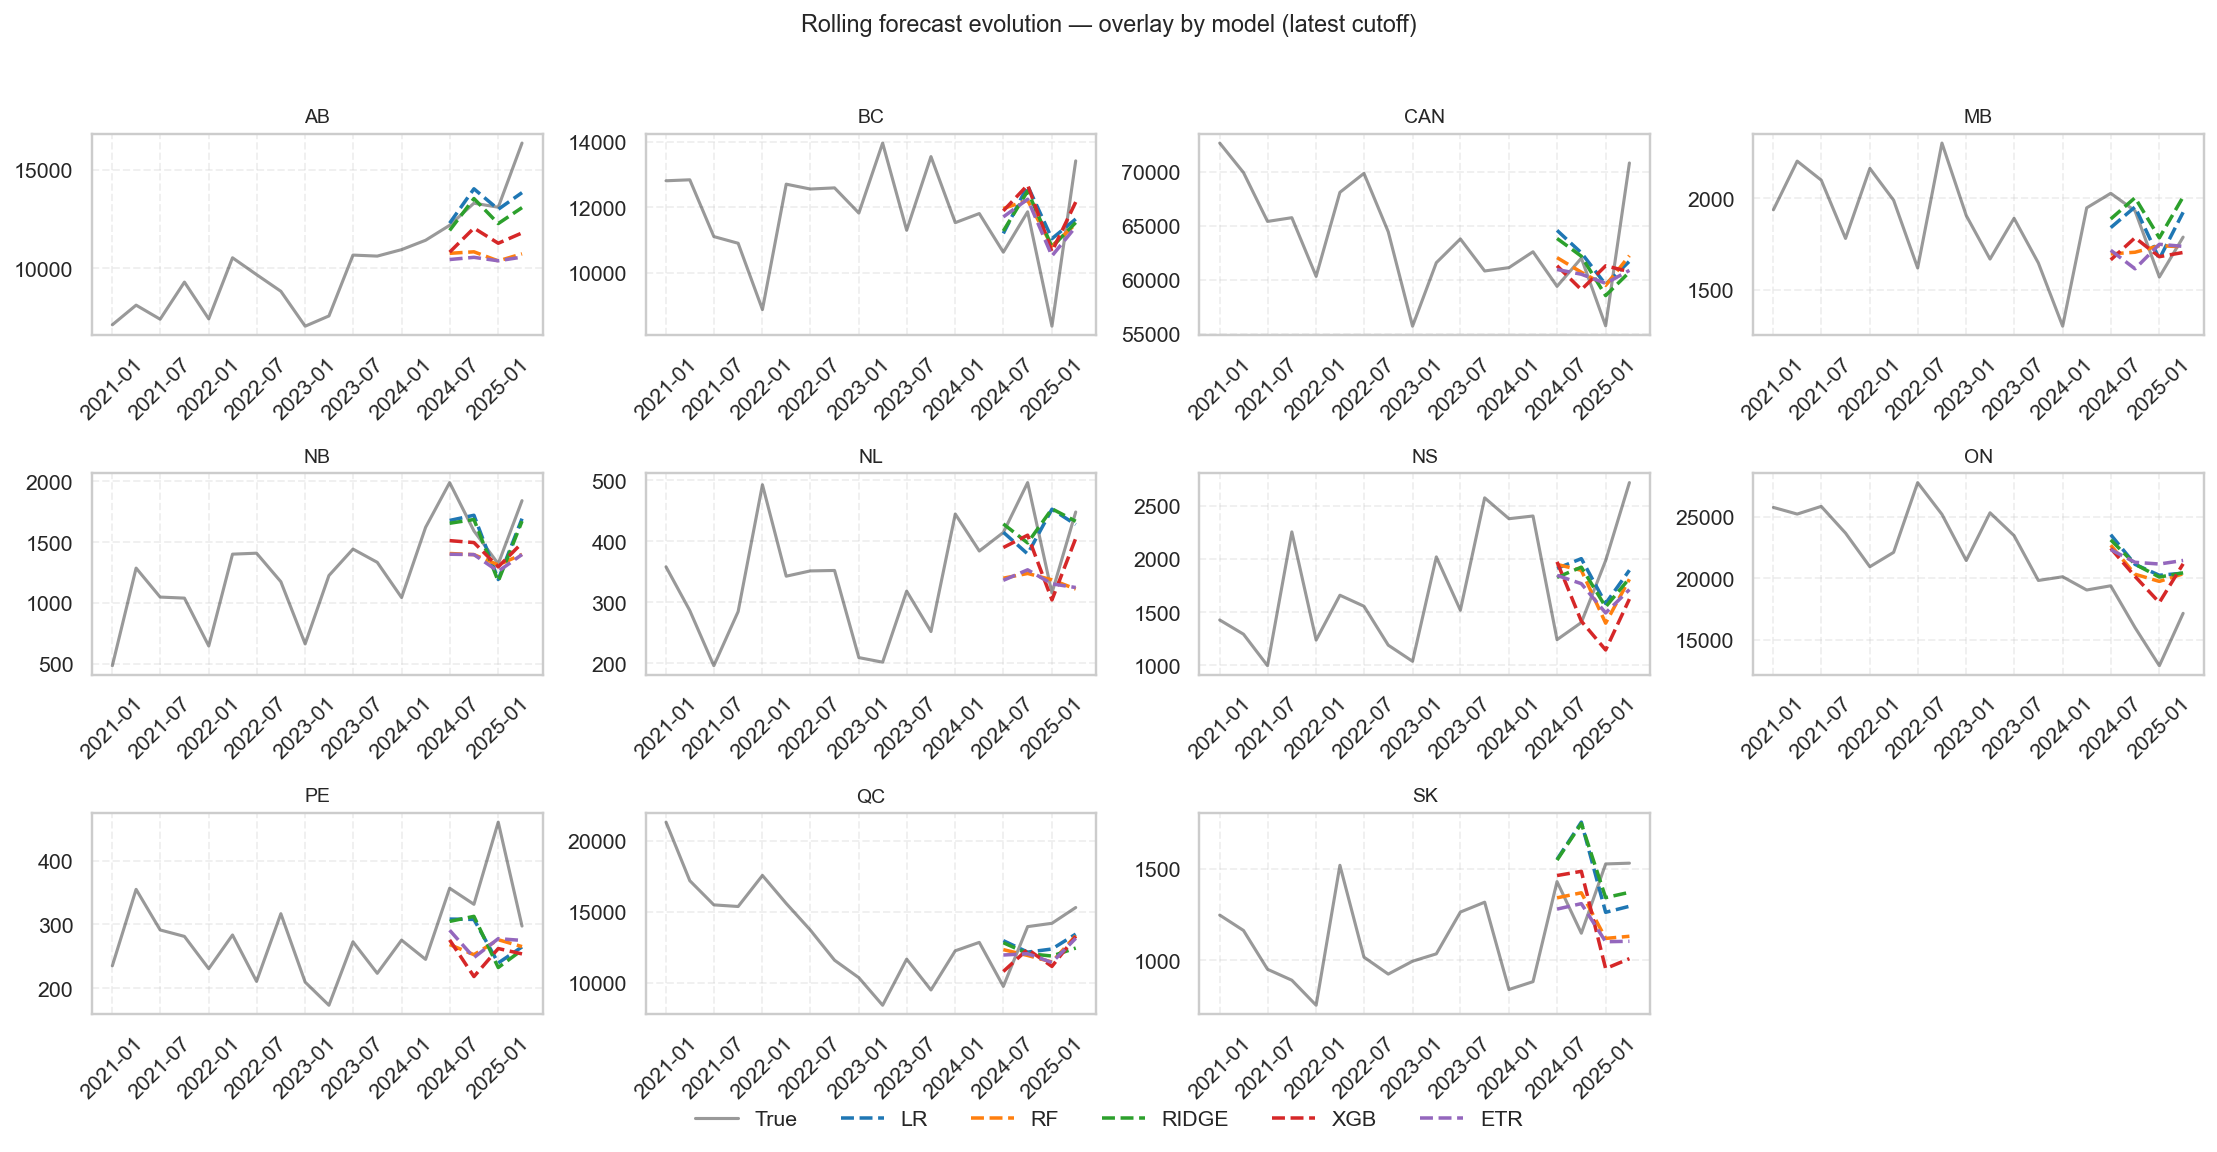

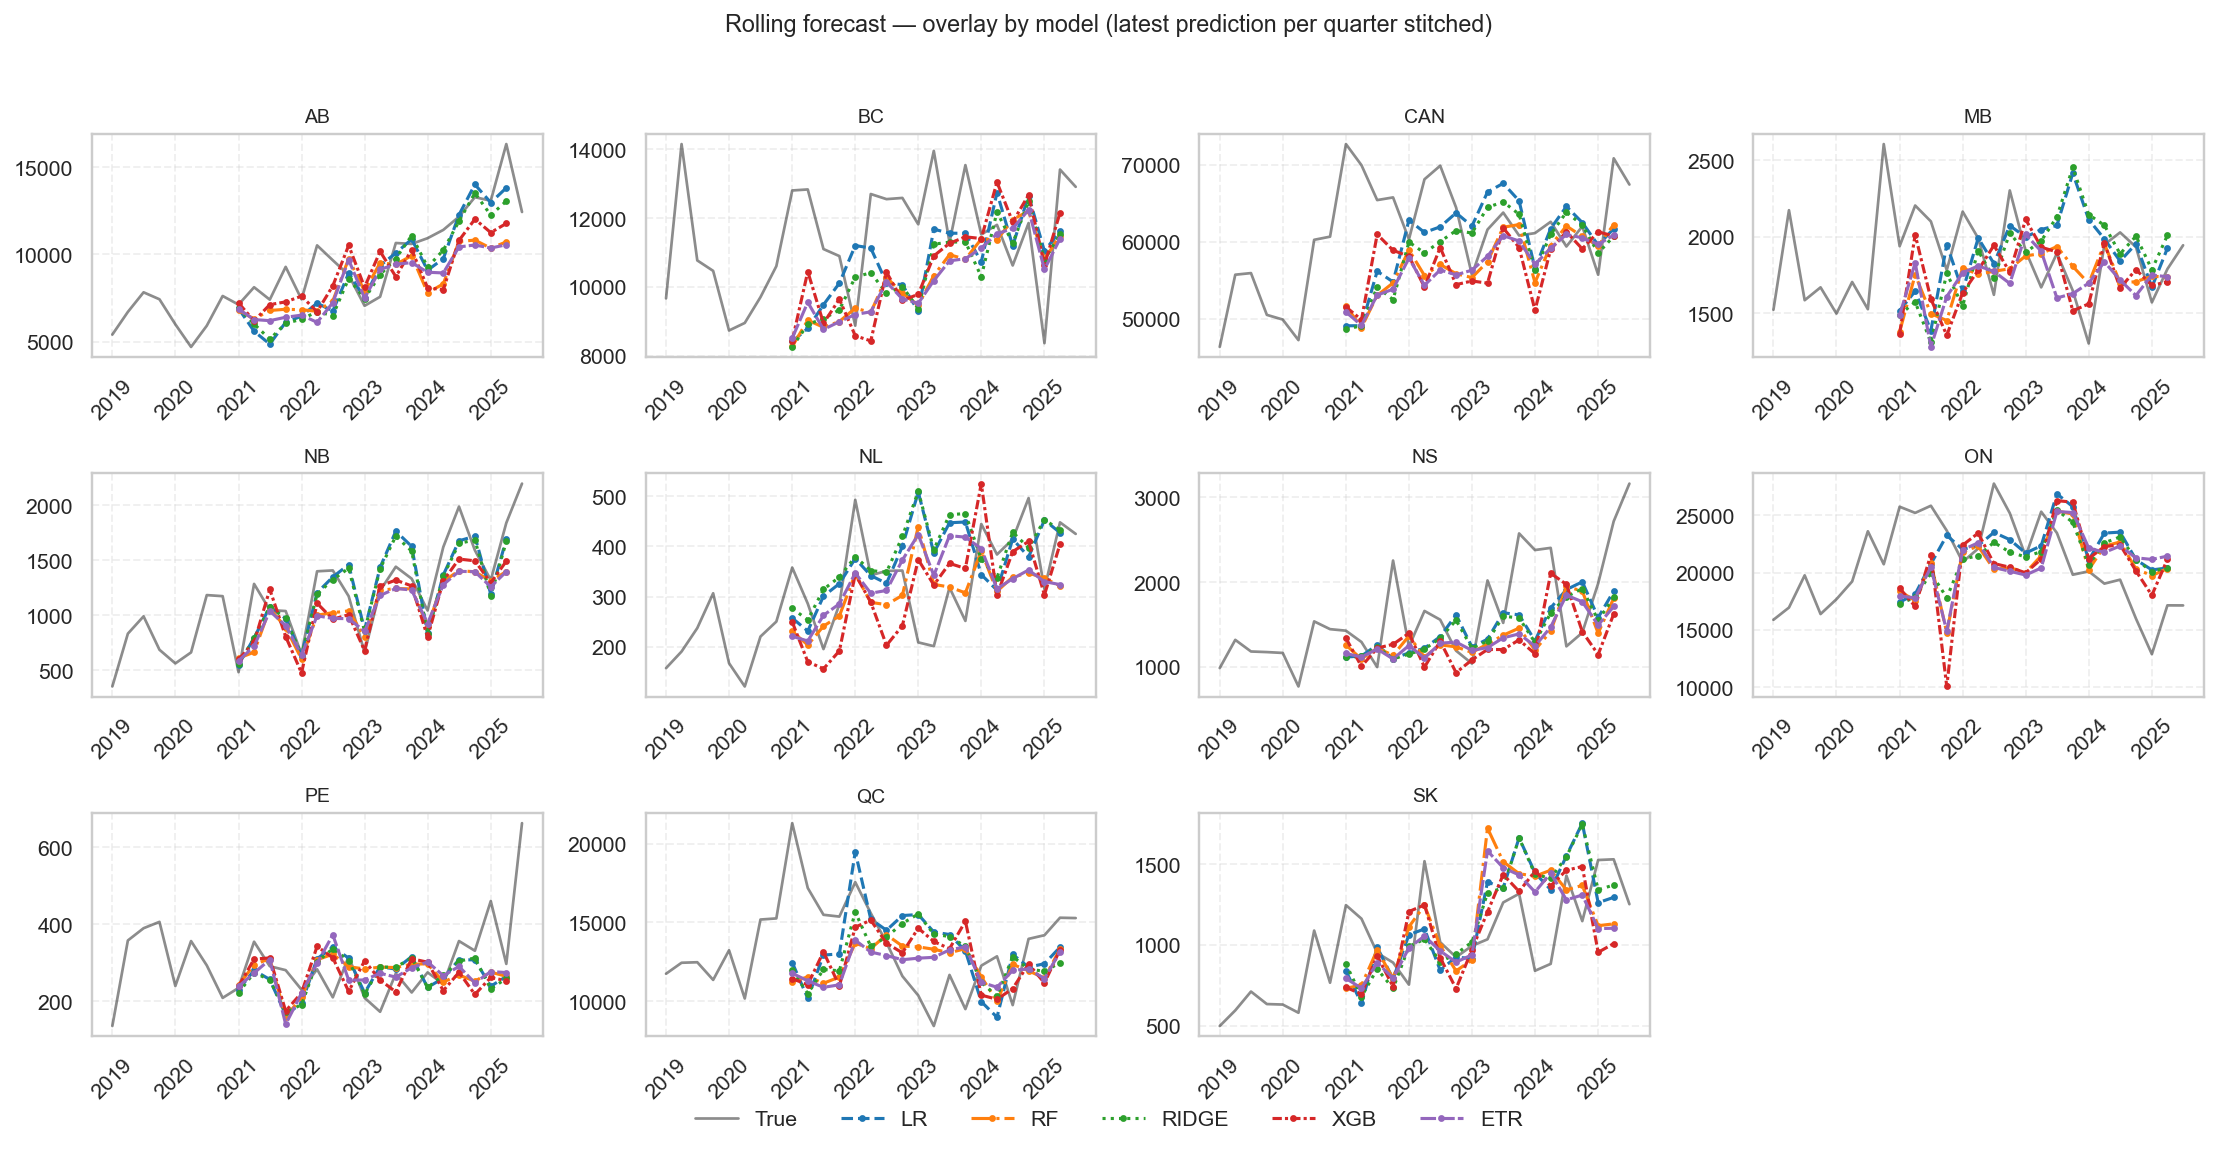

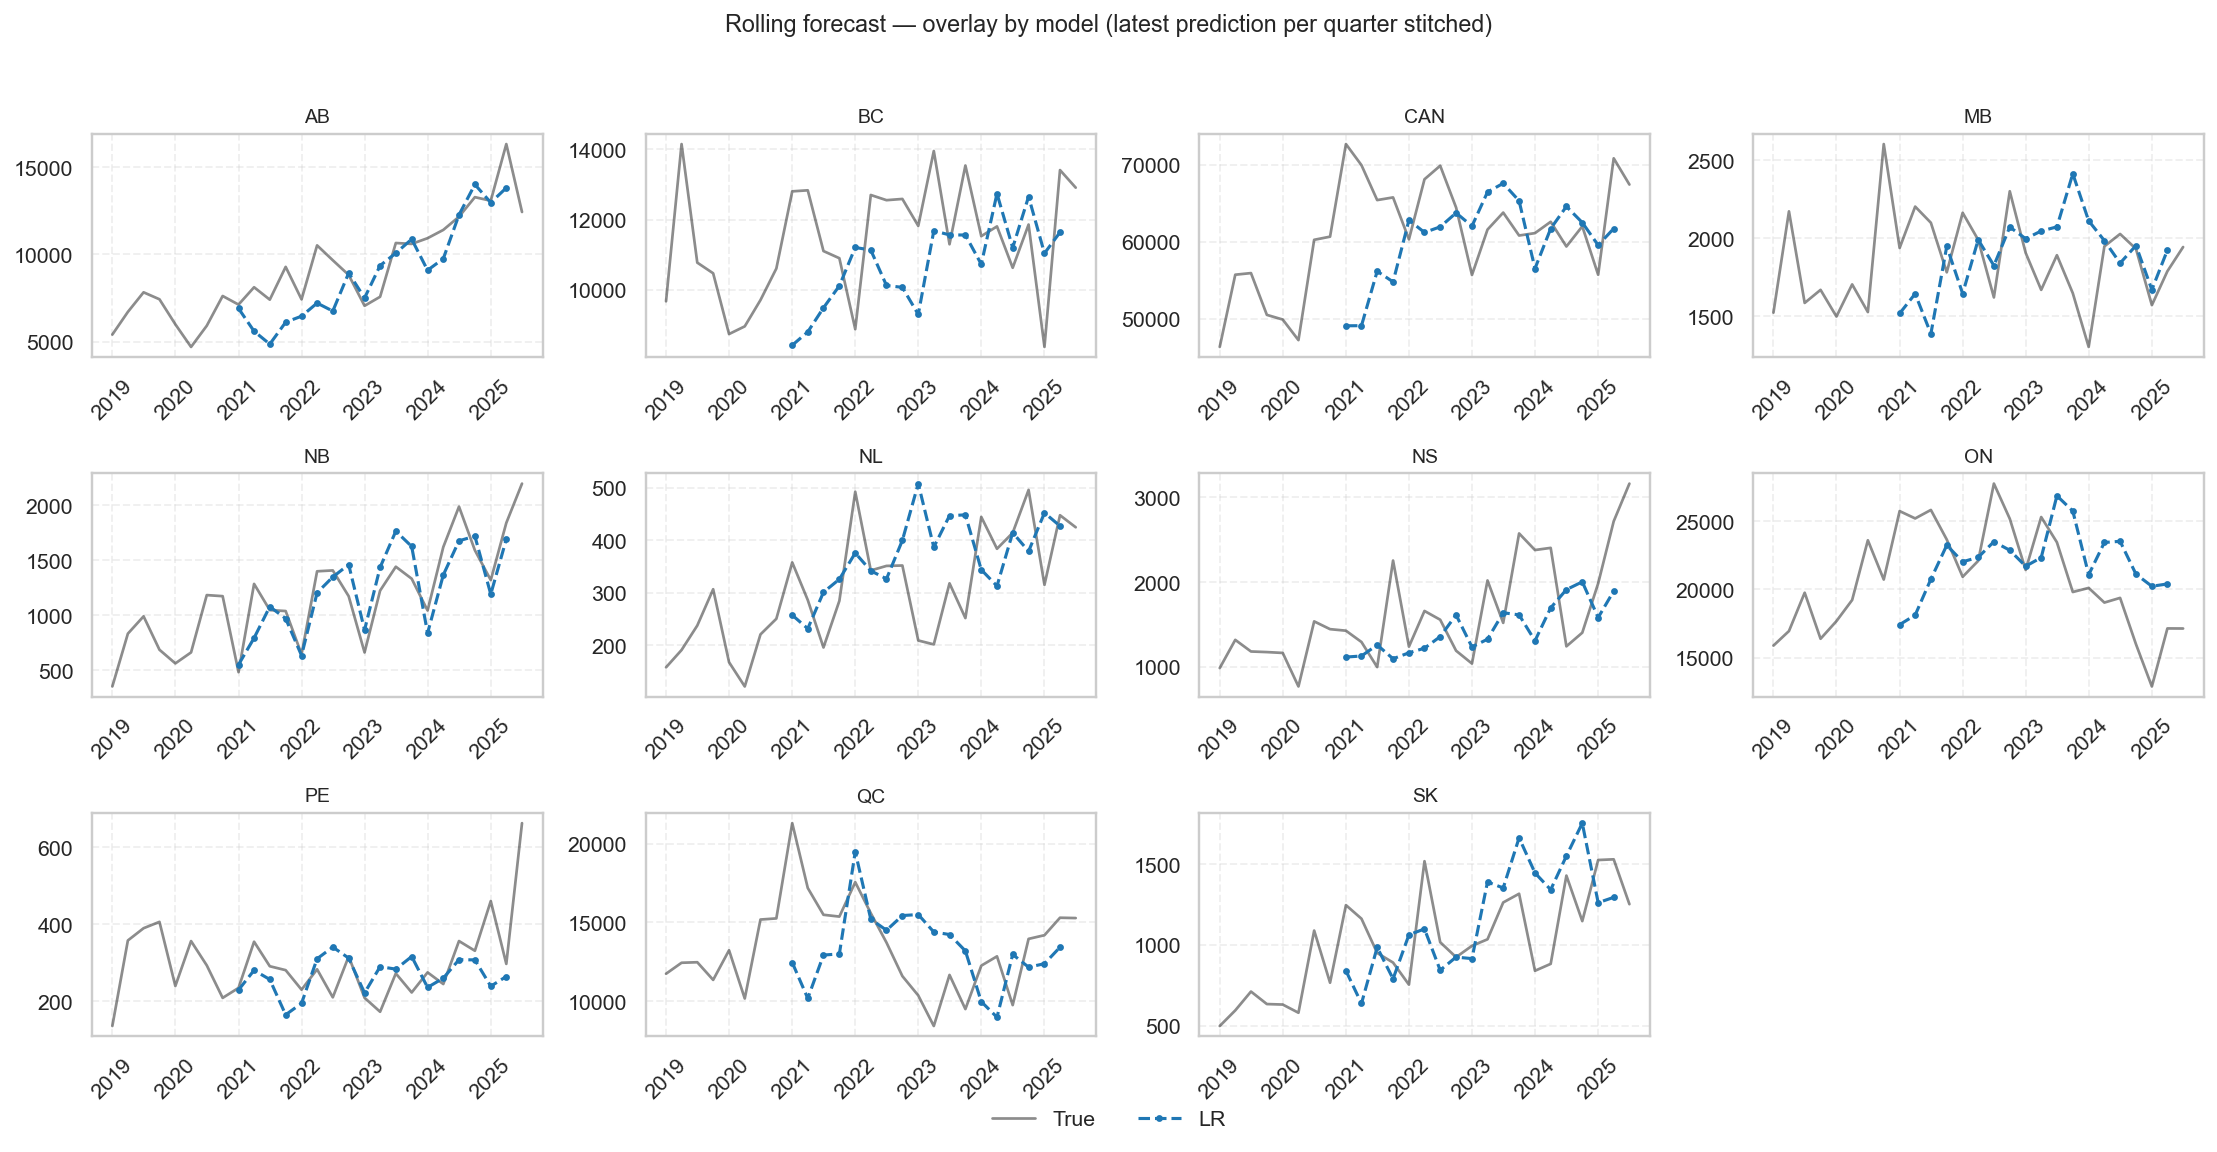

cutoff province model    quarter        y_true       y_pred  \
16  2020-10-01       ab   etr 2021-01-01   7120.583333  6864.252243   
17  2020-10-01       ab   etr 2021-04-01   8118.166667  6259.928959   
18  2020-10-01       ab   etr 2021-07-01   7404.166667  6210.101113   
19  2020-10-01       ab   etr 2021-10-01   9287.833333  6363.120515   
236 2021-04-01       ab   etr 2021-07-01   7404.166667  6199.075576   
237 2021-04-01       ab   etr 2021-10-01   9287.833333  6393.866100   
238 2021-04-01       ab   etr 2022-01-01   7420.750000  5971.097489   
239 2021-04-01       ab   etr 2022-04-01  10521.416667  5884.292858   
456 2021-10-01       ab   etr 2022-01-01   7420.750000  6515.567861   
457 2021-10-01       ab   etr 2022-04-01  10521.416667  6101.960790   

      MASE_denom  cut_rank  
16   1433.822917         0  
17   1433.822917         0  
18   1433.822917         0  
19   1433.822917         0  
236  1448.673246         1  
237  1448.673246         1  
238  1448.673246         1  
239  1448.673246         1  
456  1451.024425         2  
457  1451.024425         2

In [87]:
# ===============================
# Cell 9 — Run: load, prep, select features by choice, tune/load cache, evaluate, visualize
# ===============================
# 1) Load + frame
raw = pd.read_csv(DATA_PATH)
model_df = build_model_frame(raw)

# Ensure datetime dtype
model_df["quarter"] = pd.to_datetime(model_df["quarter"], errors="coerce")

# 2) Choose features by prediction choice
H, feat_cols = features_for_choice(PREDICTION_CHOICE)
print(f"Mode: {PREDICTION_CHOICE} | Horizon H={H}")
print("Features:", feat_cols)

# 3) Remove rows with NaNs in chosen features/target
safe_df = model_df.dropna(subset=feat_cols + ["y"]).copy()

# 4) Holdout split
train, test = chrono_split(safe_df, cutoff=CUTOFF_DATE)
print(f"Train: {train['quarter'].min().date()} → {train['quarter'].max().date()} | "
      f"Test: {test['quarter'].min().date()} → {test['quarter'].max().date()}")

# 5) Tune or load cached best params (cache key depends on choice)
best_params = load_or_tune_best_params(
    train_df=train,
    features=feat_cols,
    models_to_run=ALL_MODELS,
    prediction_choice=PREDICTION_CHOICE,
    n_iter=8,     # increase if you want more thorough tuning
    fh=H,
    initial=None,
)

# 6) Final fit on TRAIN + predict on TEST
preds_holdout = fit_predict_holdout_per_province(
    train_df=train, test_df=test, features=feat_cols,
    models_to_run=ALL_MODELS, best_params=best_params,
    prediction_choice=PREDICTION_CHOICE, target="dwelling_starts"
)

# 7) Summary tables
print("\n=== Holdout averages across provinces (tuned) ===")
g_model, g_pm = summarize_metrics_table(preds_holdout)

naive_holdout = add_naive_to_holdout(
    safe_df=safe_df, train_df=train, test_df=test,
    horizon=H, target_col="dwelling_starts"
)

preds_holdout_with_naive = pd.concat([preds_holdout, naive_holdout], ignore_index=True)


# 8) Train–Test overlay (multiple models per province)
plot_holdout_overlay(preds_holdout_with_naive, ALL_MODELS)

plot_holdout_overlay(preds_holdout_with_naive, ['lr'])

# 9) Rolling evolution — latest cutoff overlay
preds_roll = rolling_evolution_overlay(
    df_all=safe_df,
    features=feat_cols,
    best_params=best_params,
    models_to_plot=ALL_MODELS,
    fh=H,
    initial="2012-12-31",
    step=2,                  # speed/coverage trade-off
    last_k_cutoffs=8,
    show_history=False,
    return_df=True,
)

naive_roll = add_naive_to_holdout(
    safe_df=safe_df, train_df=train, test_df=test,
    horizon=H, target_col="dwelling_starts"
)

preds_roll_with_naive = pd.concat([preds_roll, naive_roll], ignore_index=True)

# 10) Rolling stitched lines (latest per quarter across folds)
if preds_roll is not None:
    d_latest = latest_per_quarter(preds_roll_with_naive)
    rolling_overlay_lines(d_latest, ALL_MODELS)
    
if preds_roll is not None:
    d_latest = latest_per_quarter(preds_roll_with_naive)
    rolling_overlay_lines(d_latest, ['lr'])

# Peek
preds_roll.head(10) if preds_roll is not None else None


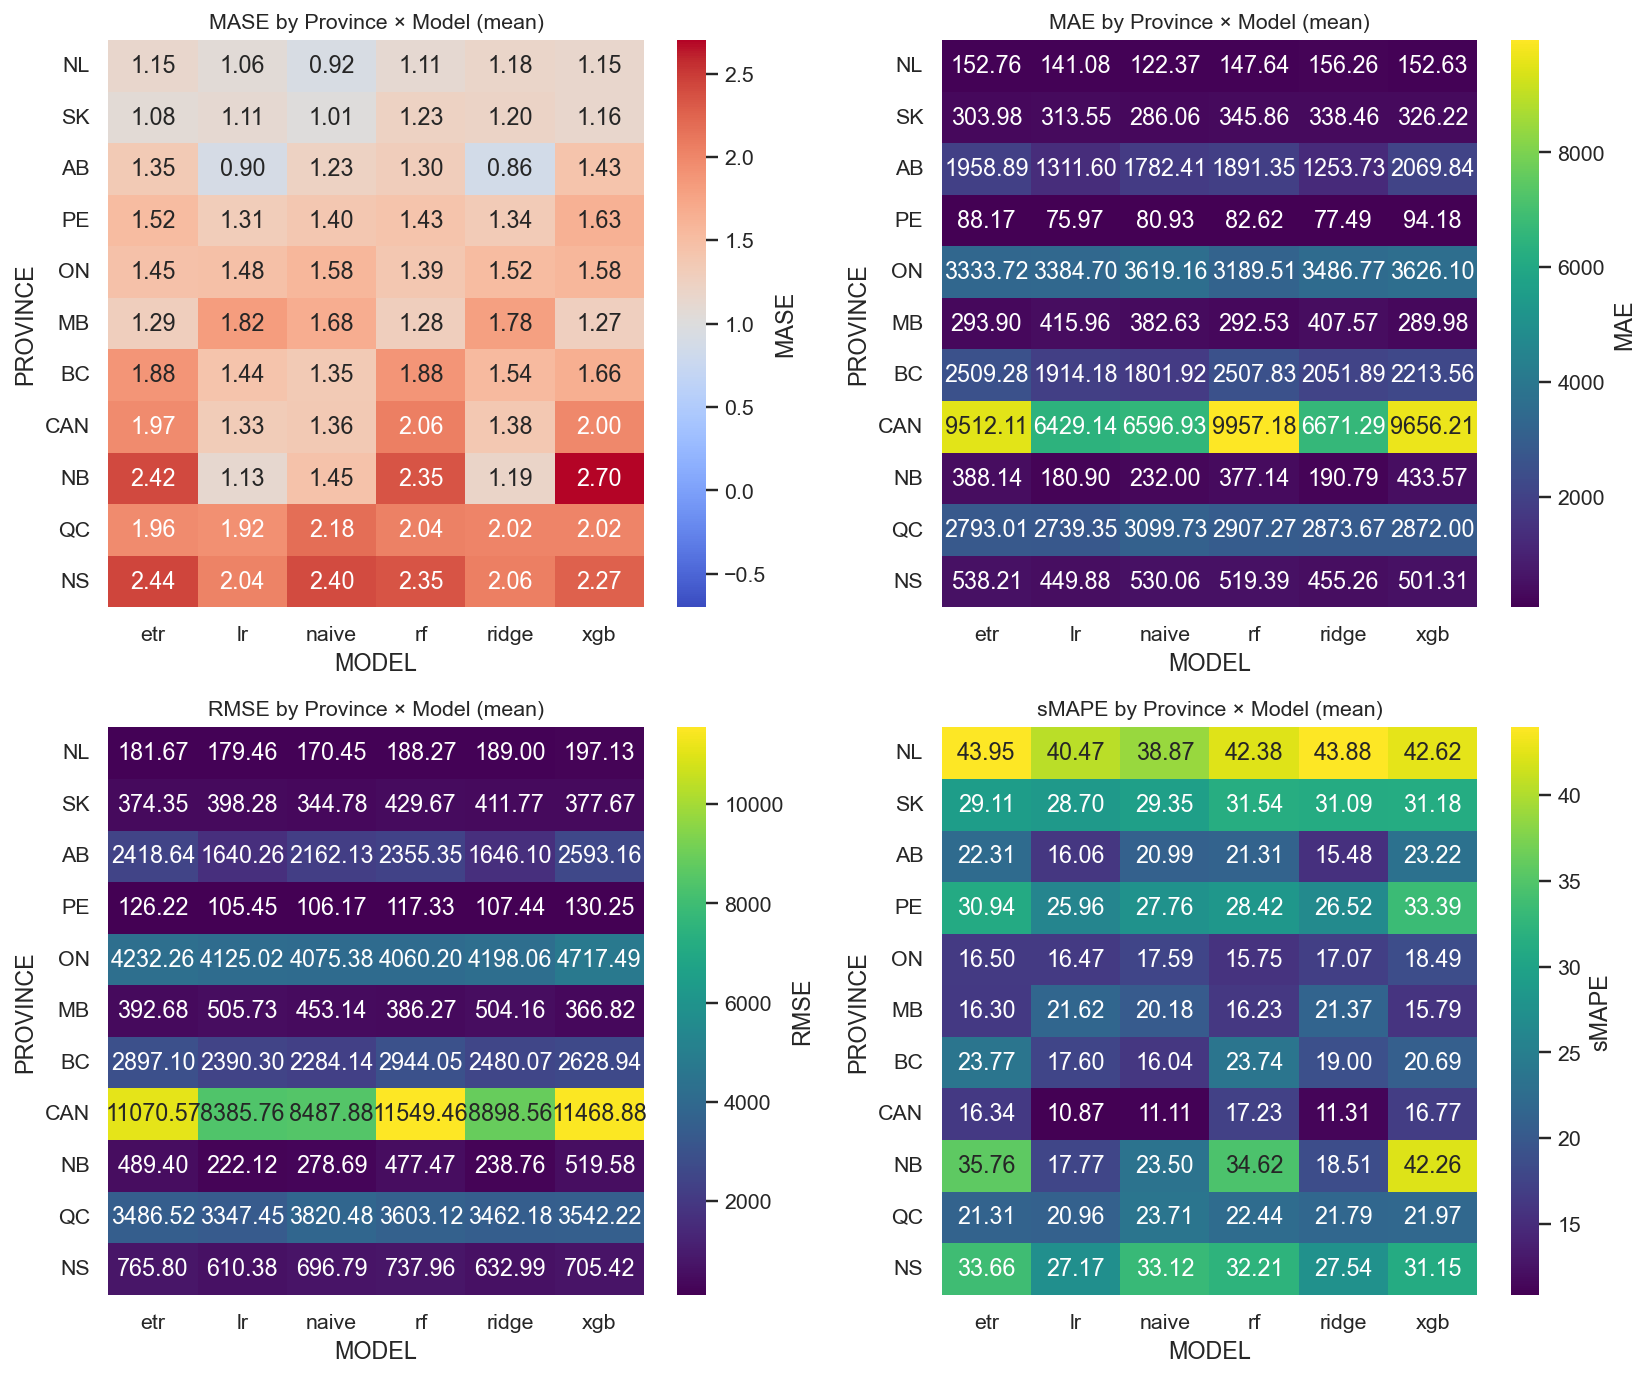

In [89]:
plot_perf_heatmaps_from_preds(
    preds_df=preds_holdout_with_naive,
    metrics=("MASE","MAE","RMSE","sMAPE"),
    center_on_1=("MASE",),
    mase_fallback_to_existing_col=True
)


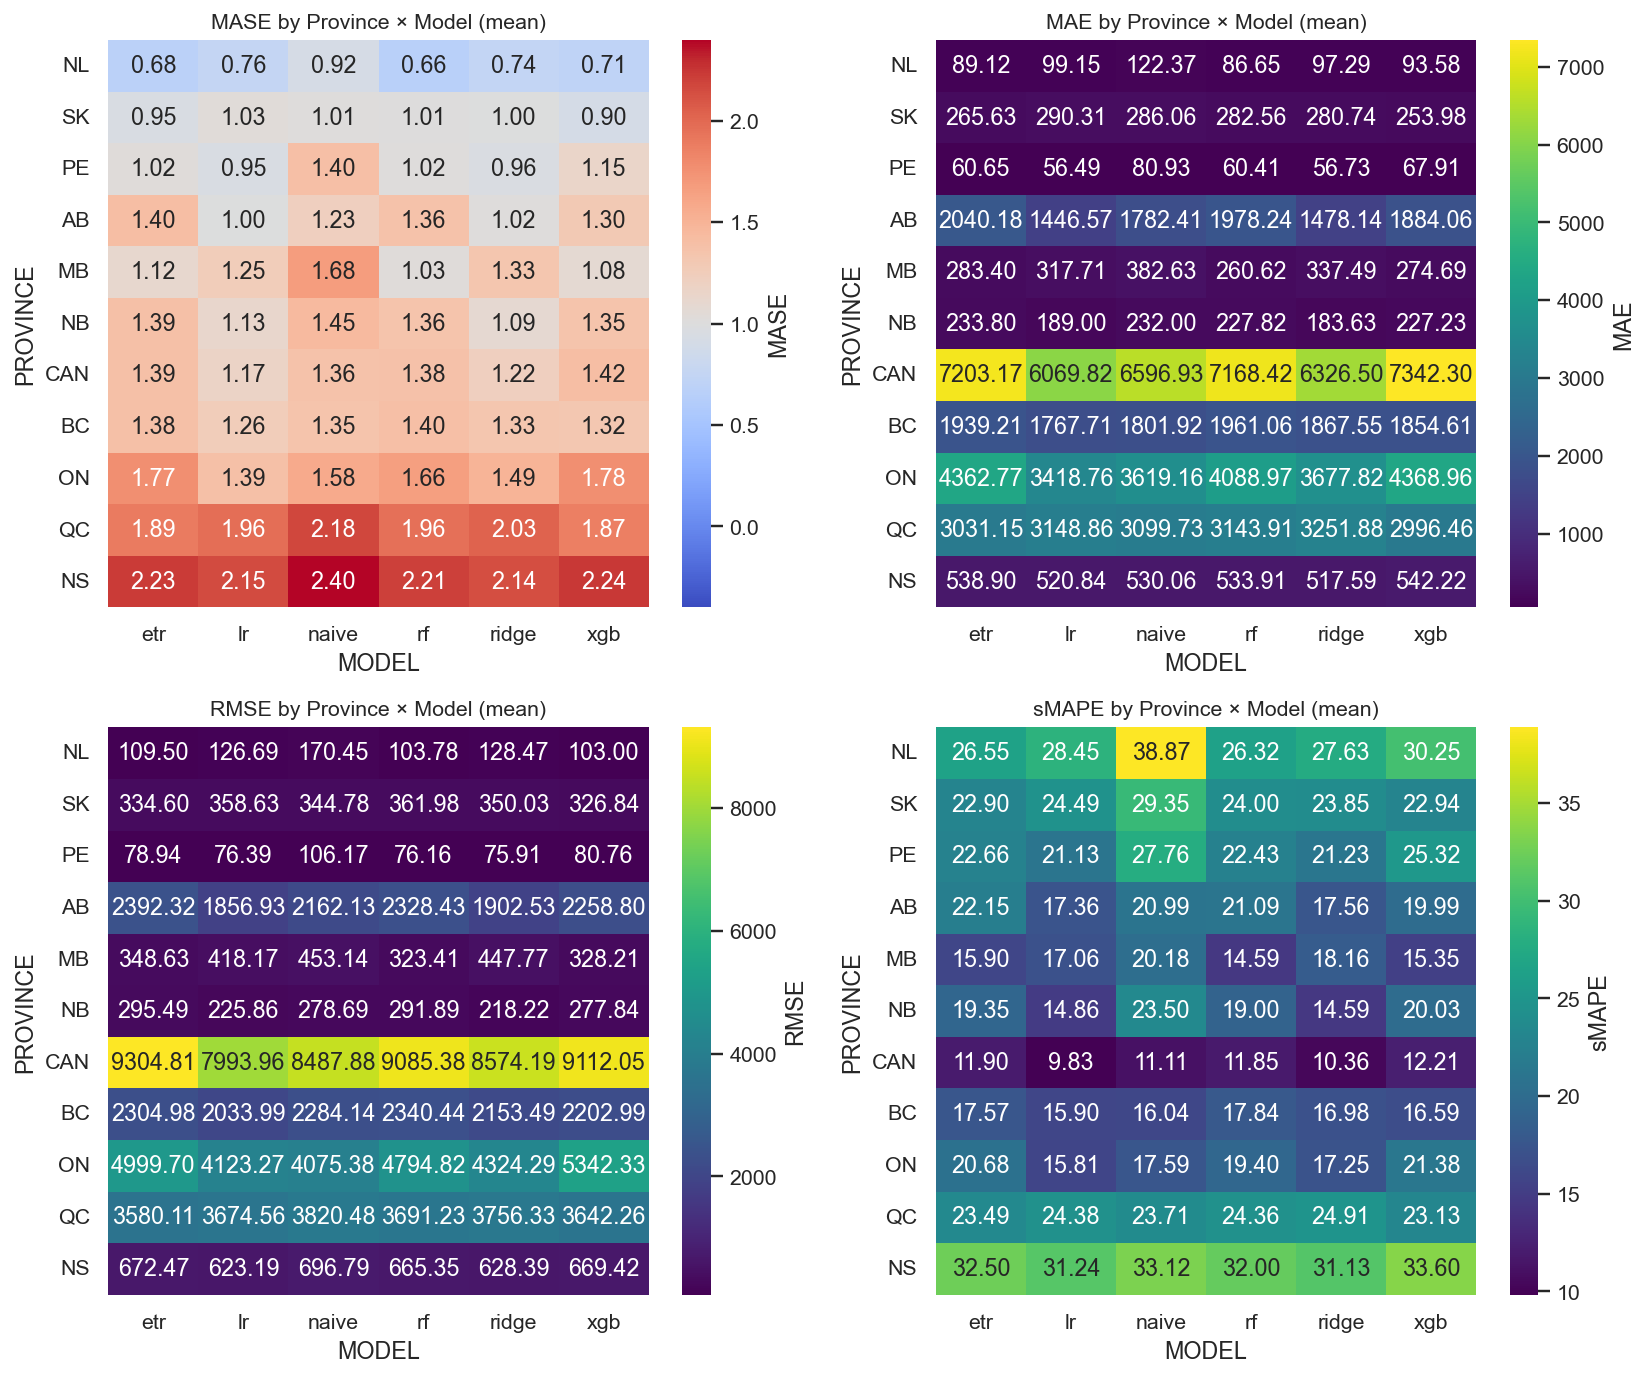

cutoff province model    quarter        y_true       y_pred  \
0 2020-10-01       ab   etr 2021-01-01   7120.583333  6864.252243   
1 2020-10-01       ab   etr 2021-04-01   8118.166667  6259.928959   
2 2020-10-01       ab   etr 2021-07-01   7404.166667  6210.101113   
3 2020-10-01       ab   etr 2021-10-01   9287.833333  6363.120515   
4 2021-04-01       ab   etr 2021-07-01   7404.166667  6199.075576   
5 2021-04-01       ab   etr 2021-10-01   9287.833333  6393.866100   
6 2021-04-01       ab   etr 2022-01-01   7420.750000  5971.097489   
7 2021-04-01       ab   etr 2022-04-01  10521.416667  5884.292858   
8 2021-10-01       ab   etr 2022-01-01   7420.750000  6515.567861   
9 2021-10-01       ab   etr 2022-04-01  10521.416667  6101.960790   

    MASE_denom  cut_rank  MAE  RMSE  sMAPE  MASE  MAPE  
0  1433.822917       0.0  NaN   NaN    NaN   NaN   NaN  
1  1433.822917       0.0  NaN   NaN    NaN   NaN   NaN  
2  1433.822917       0.0  NaN   NaN    NaN   NaN   NaN  
3  1433.822917       0.0  NaN   NaN    NaN   NaN   NaN  
4  1448.673246       1.0  NaN   NaN    NaN   NaN   NaN  
5  1448.673246       1.0  NaN   NaN    NaN   NaN   NaN  
6  1448.673246       1.0  NaN   NaN    NaN   NaN   NaN  
7  1448.673246       1.0  NaN   NaN    NaN   NaN   NaN  
8  1451.024425       2.0  NaN   NaN    NaN   NaN   NaN  
9  1451.024425       2.0  NaN   NaN    NaN   NaN   NaN

In [90]:

plot_perf_heatmaps_from_preds(
    preds_df=preds_roll_with_naive,
    metrics=("MASE","MAE","RMSE","sMAPE"),
    center_on_1=("MASE",),
    mase_denom_col="MASE_denom"
)

preds_roll_with_naive.head(10)

## Next Q

In [91]:
# Paths
DATA_PATH  = "data/housing_adequacy_dataset.csv"

# Split
CUTOFF_DATE = "2018-12-31"  # train ≤ cutoff, test > cutoff

# Available models
ALL_MODELS = ["lr", "rf", "ridge", "xgb", "etr"]  # trim as needed

# ===============================
# Choose prediction target here:
# "next_quarter"            -> H=1
# "same_quarter_next_year"  -> H=4
# ===============================
PREDICTION_CHOICE = "next_quarter" #"same_quarter_next_year" or "next_quarter"

Mode: next_quarter | Horizon H=1
Features: ['dwelling_starts_lag1', 'dwelling_starts_lag4', 'pop_change_q_lag1', 'needed_units_q_lag1']
Train: 1991-01-01 → 2018-10-01 | Test: 2019-01-01 → 2025-07-01
🔁 Loading cached best parameters from best_params_cache_h1.json

=== Holdout averages across provinces (tuned) ===


MAE     RMSE  sMAPE  MASE
model                               
ridge  1262.46  1624.43  22.60  1.69
lr     1269.97  1618.60  22.32  1.68
etr    1727.98  2078.84  26.71  2.06
rf     1743.90  2101.72  26.68  2.05
xgb    1777.31  2152.05  28.84  2.16

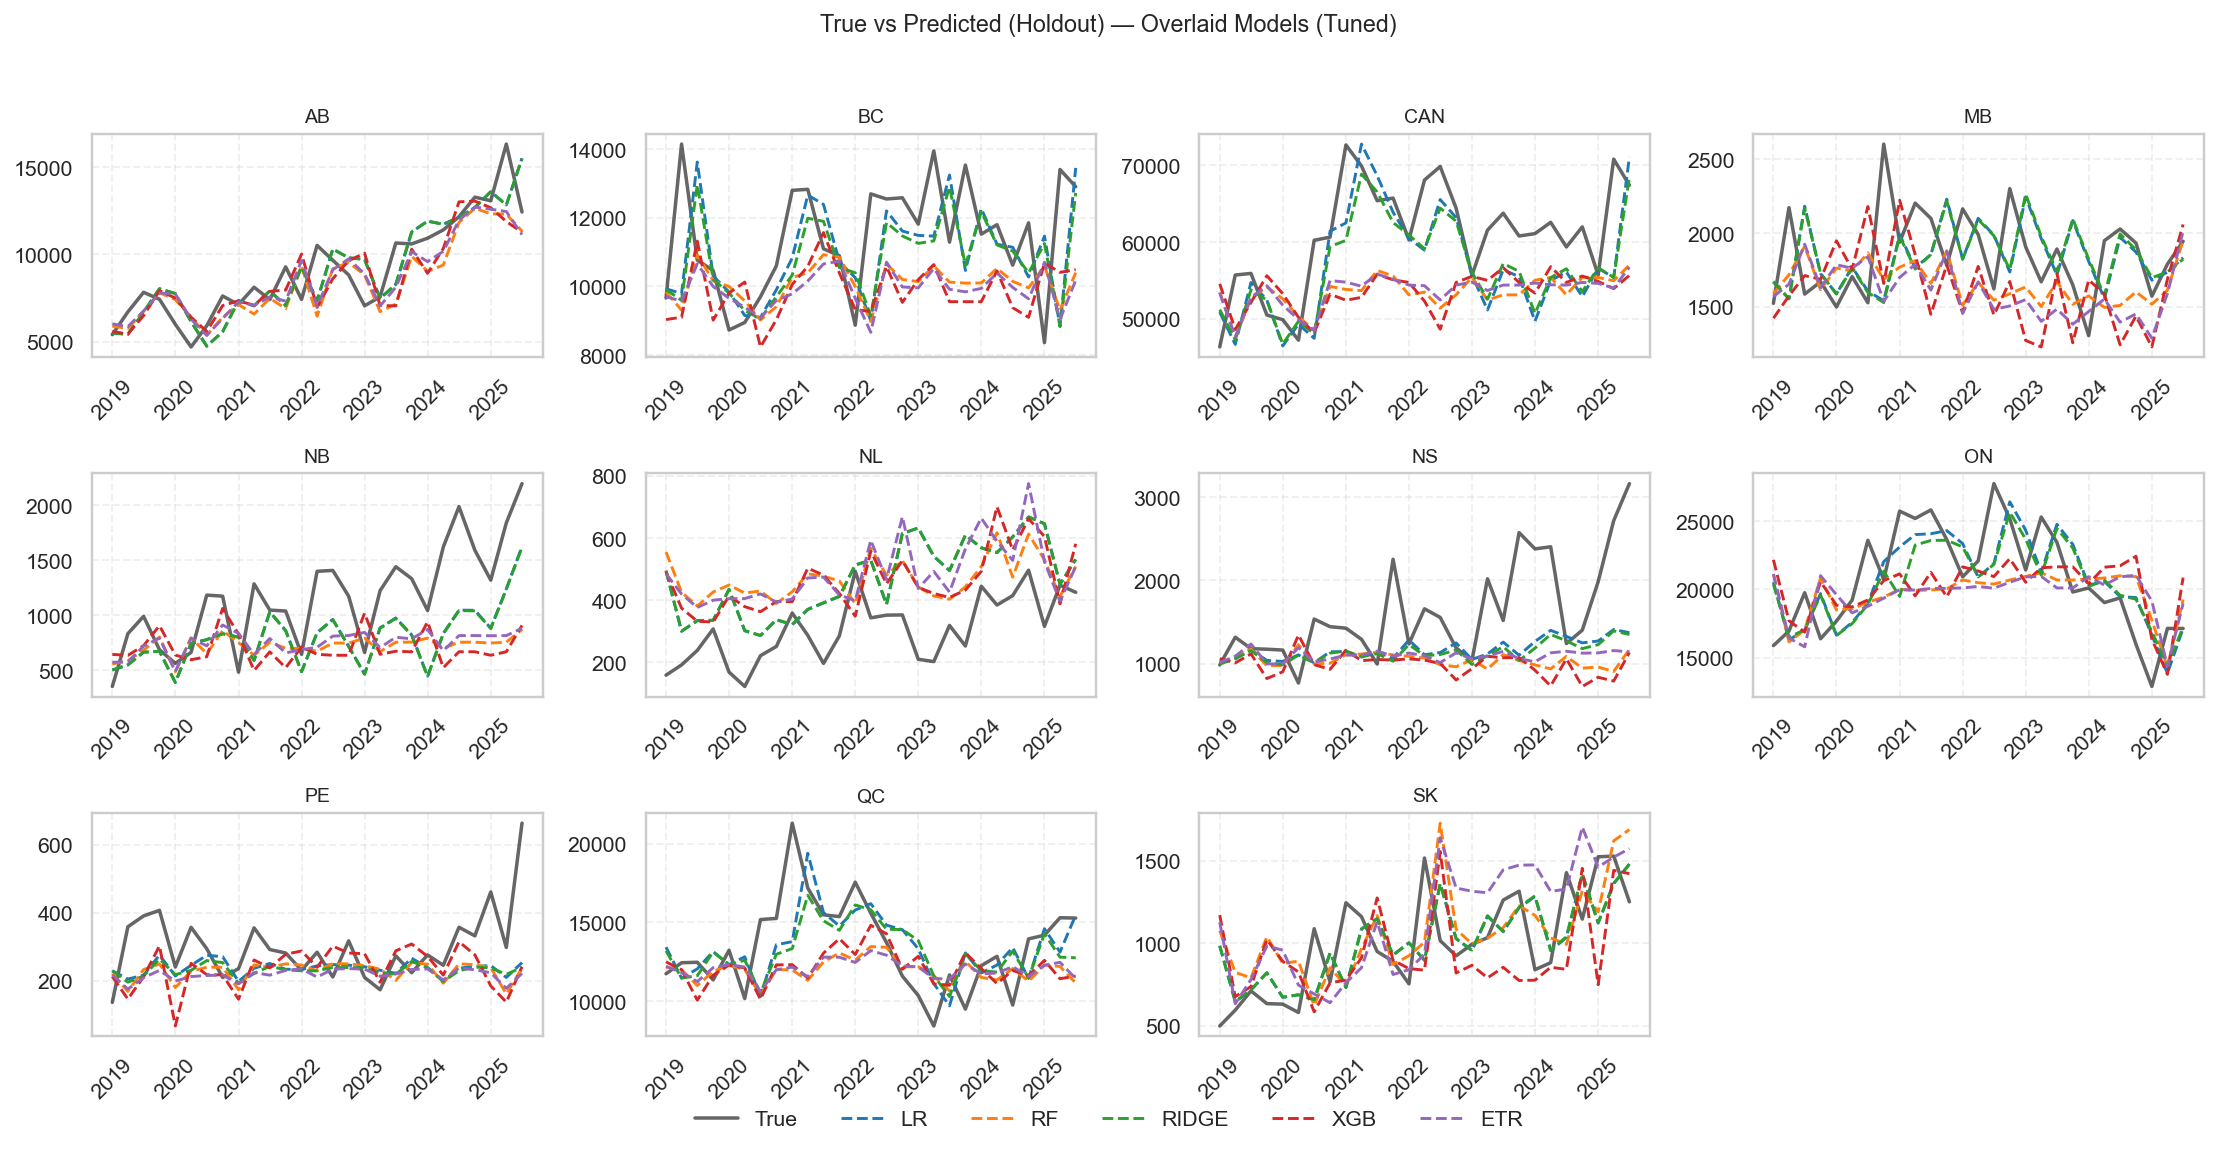

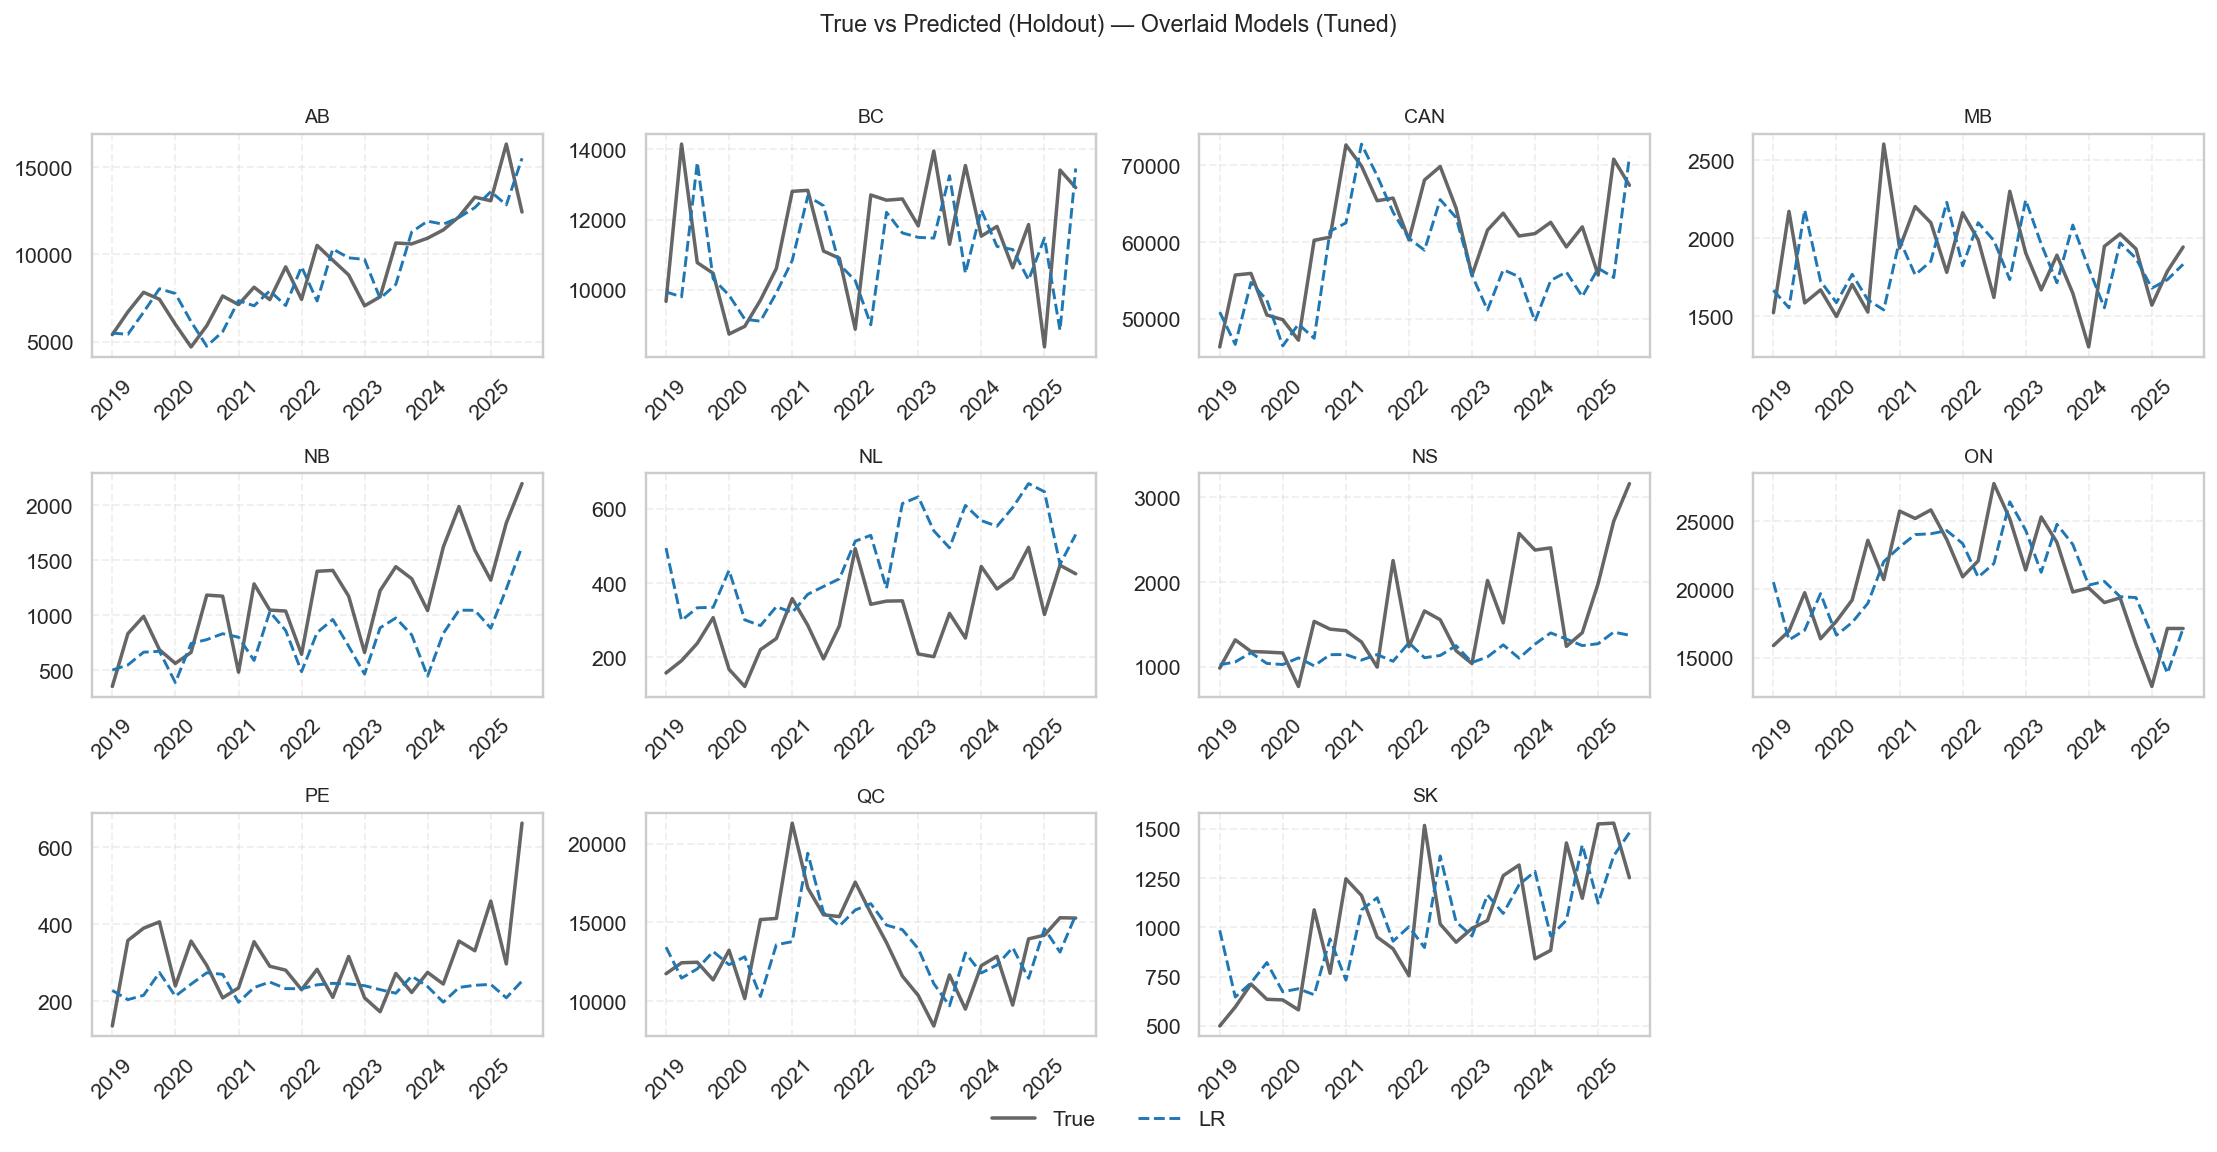

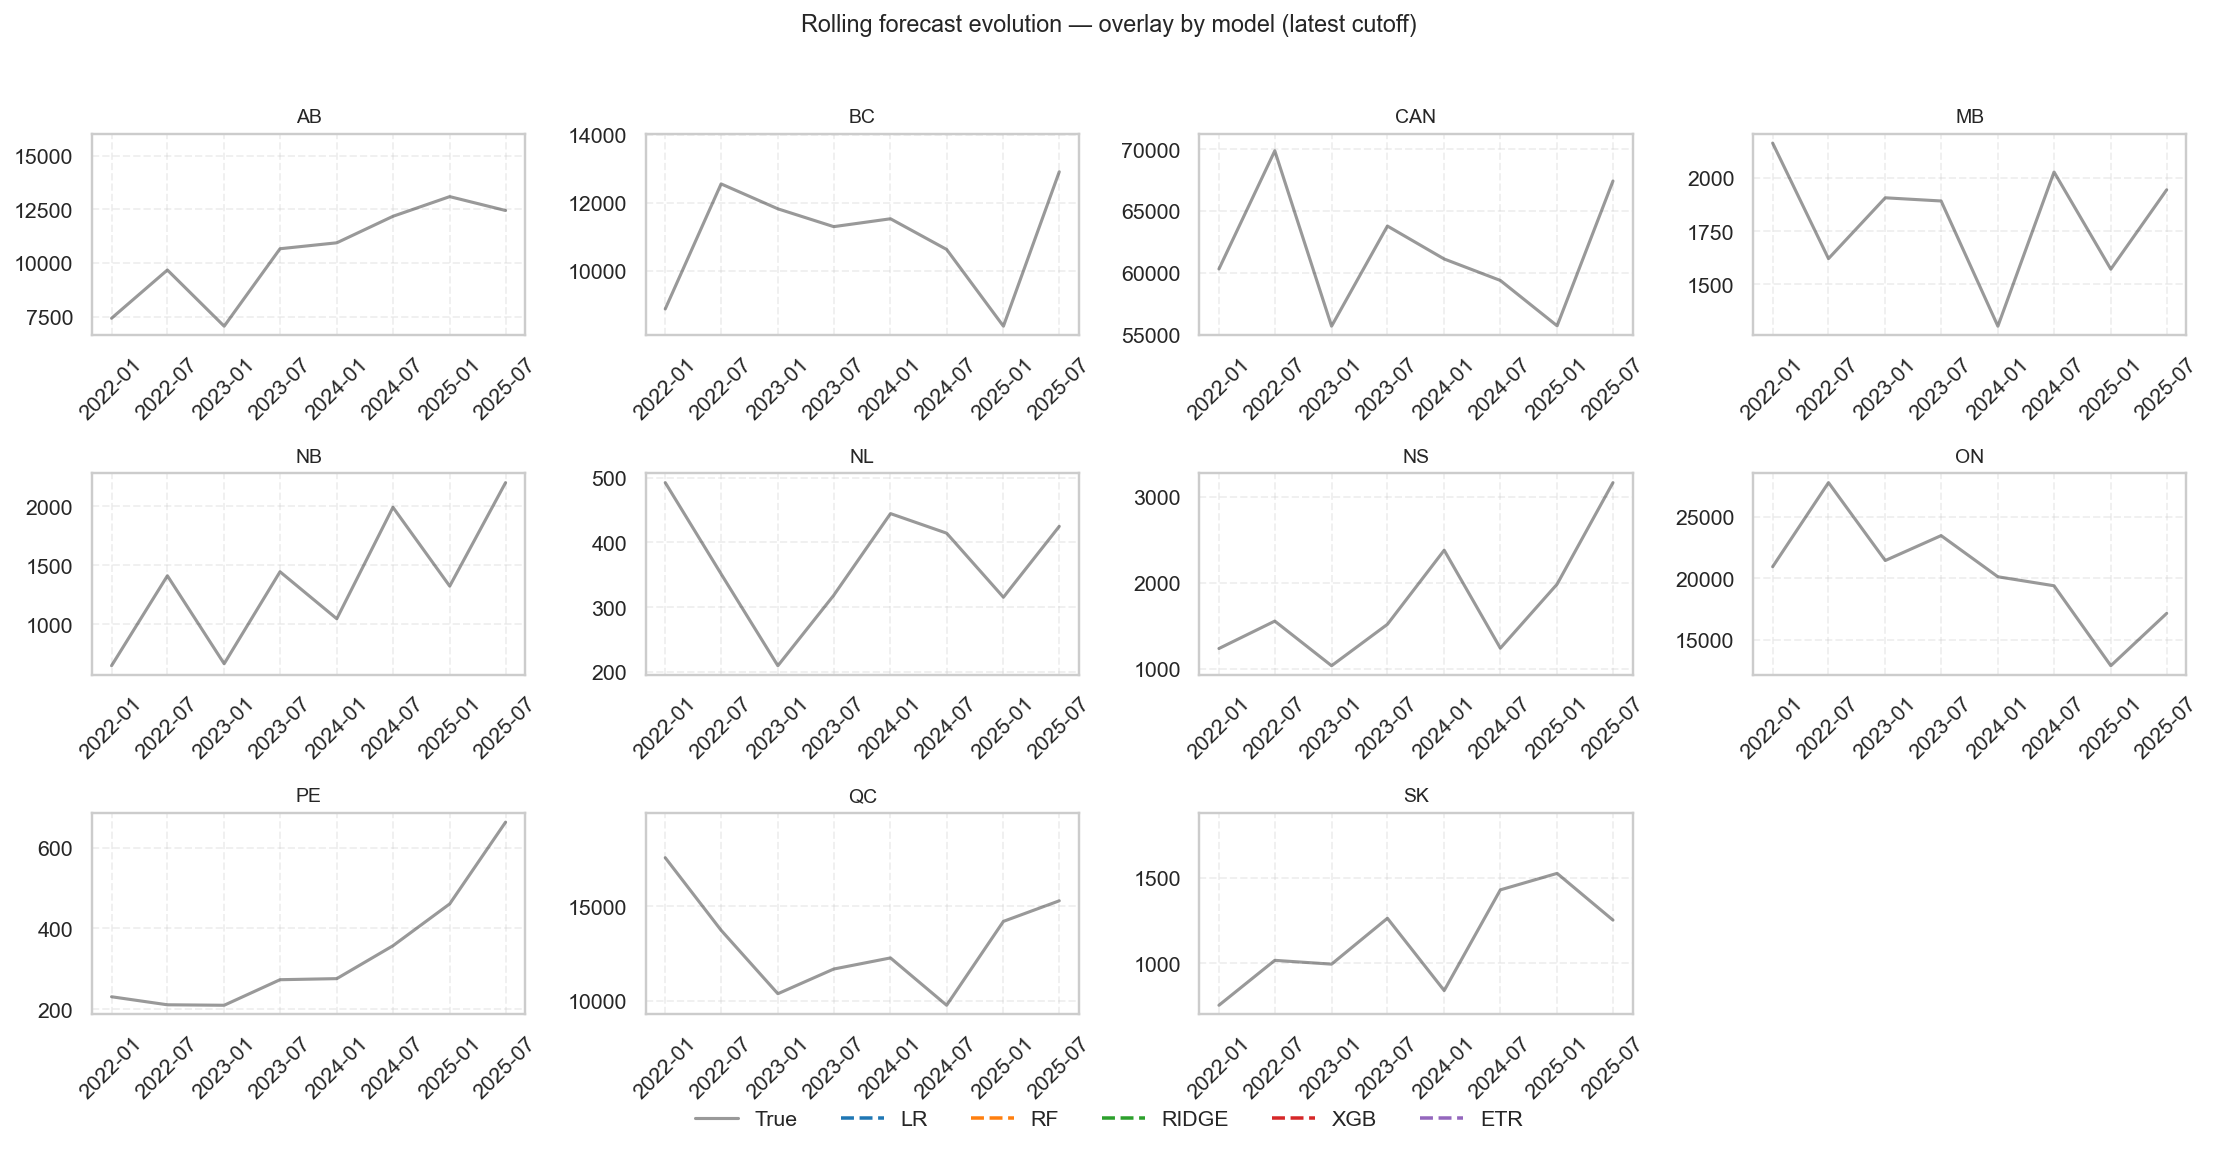

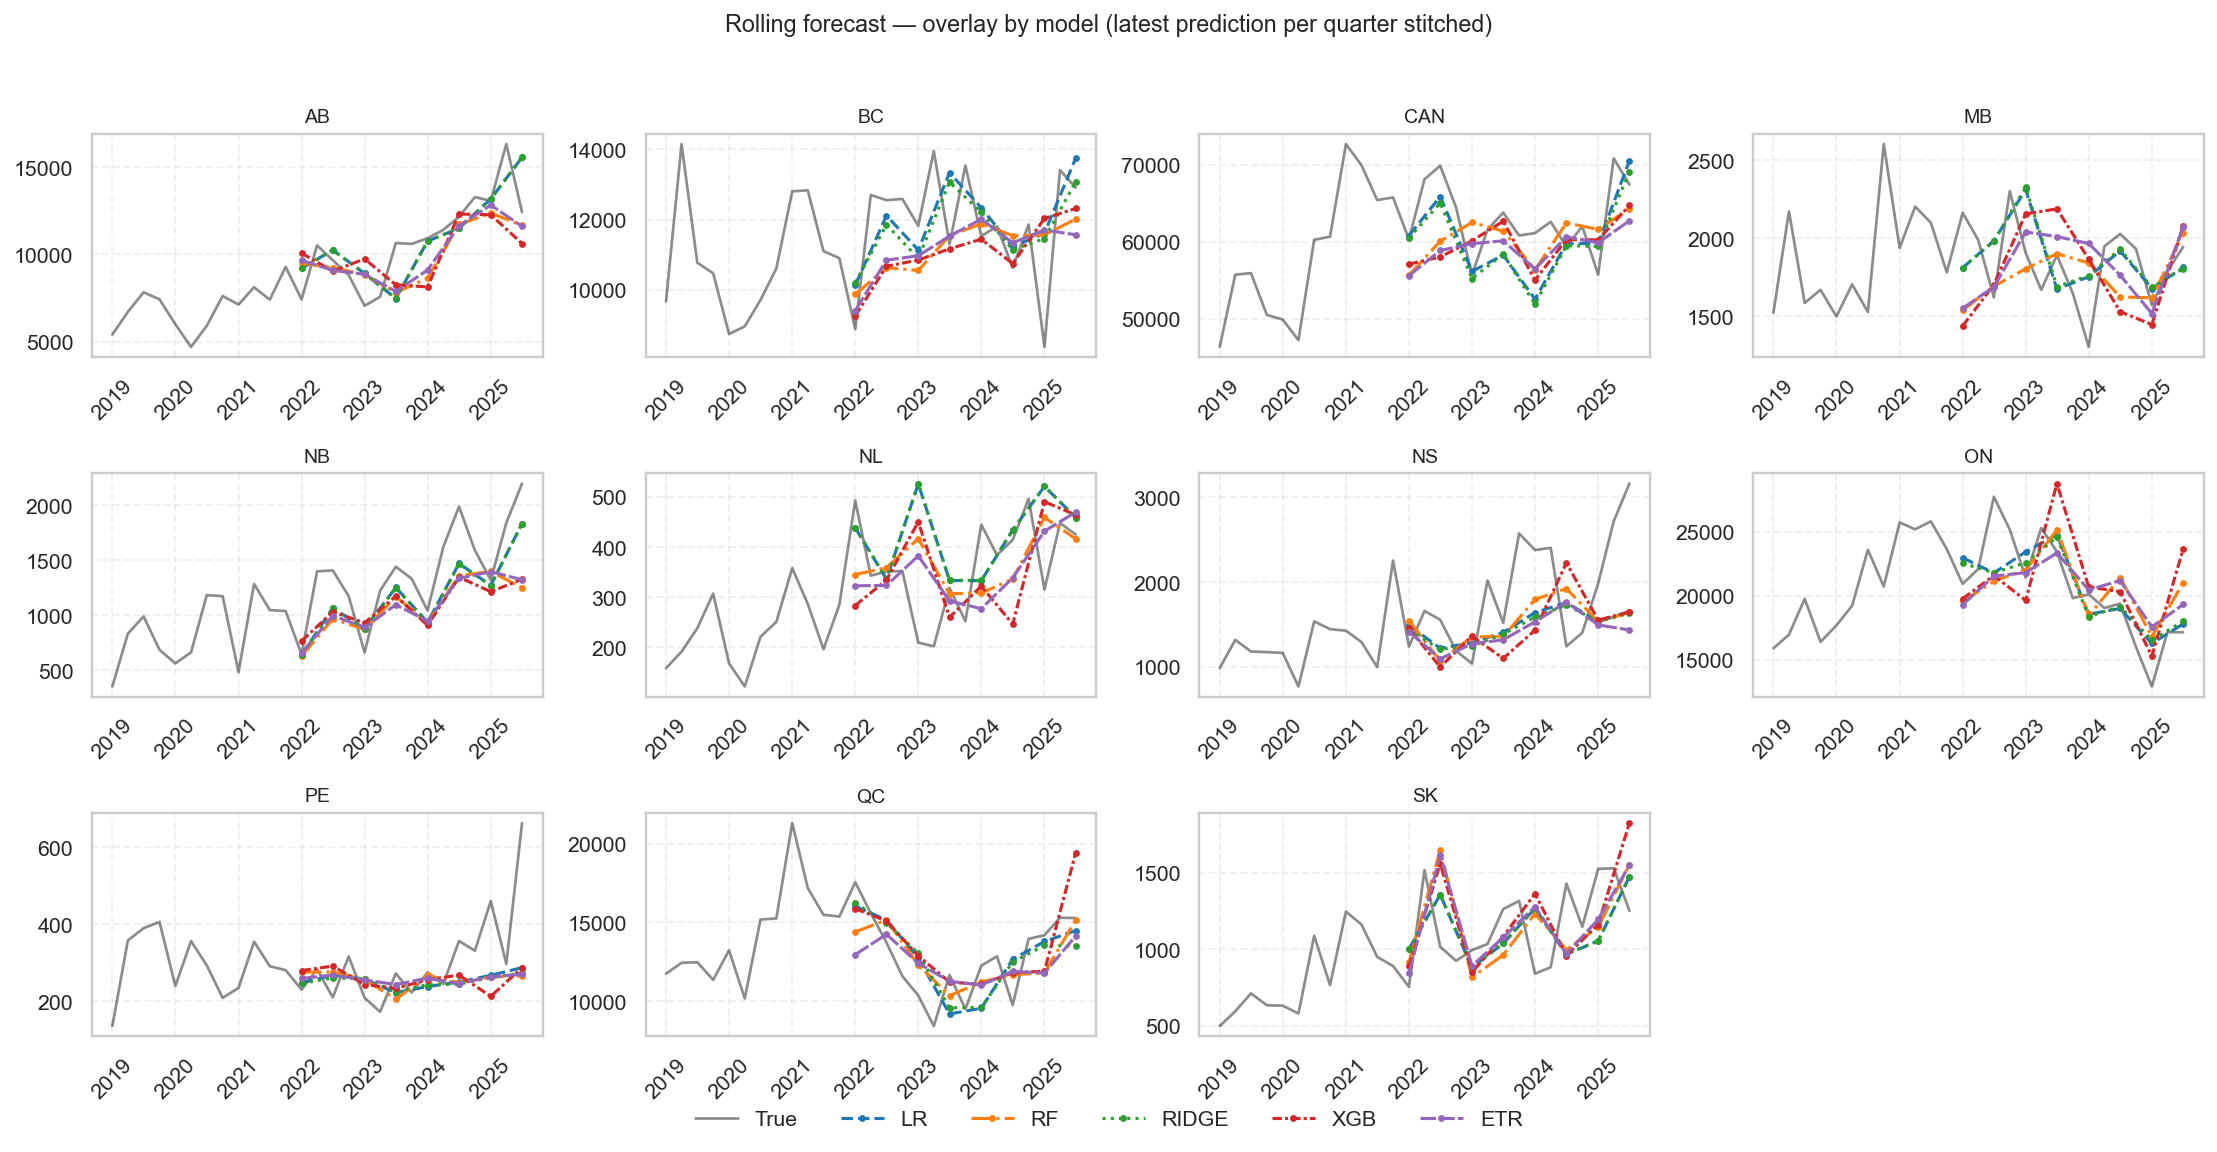

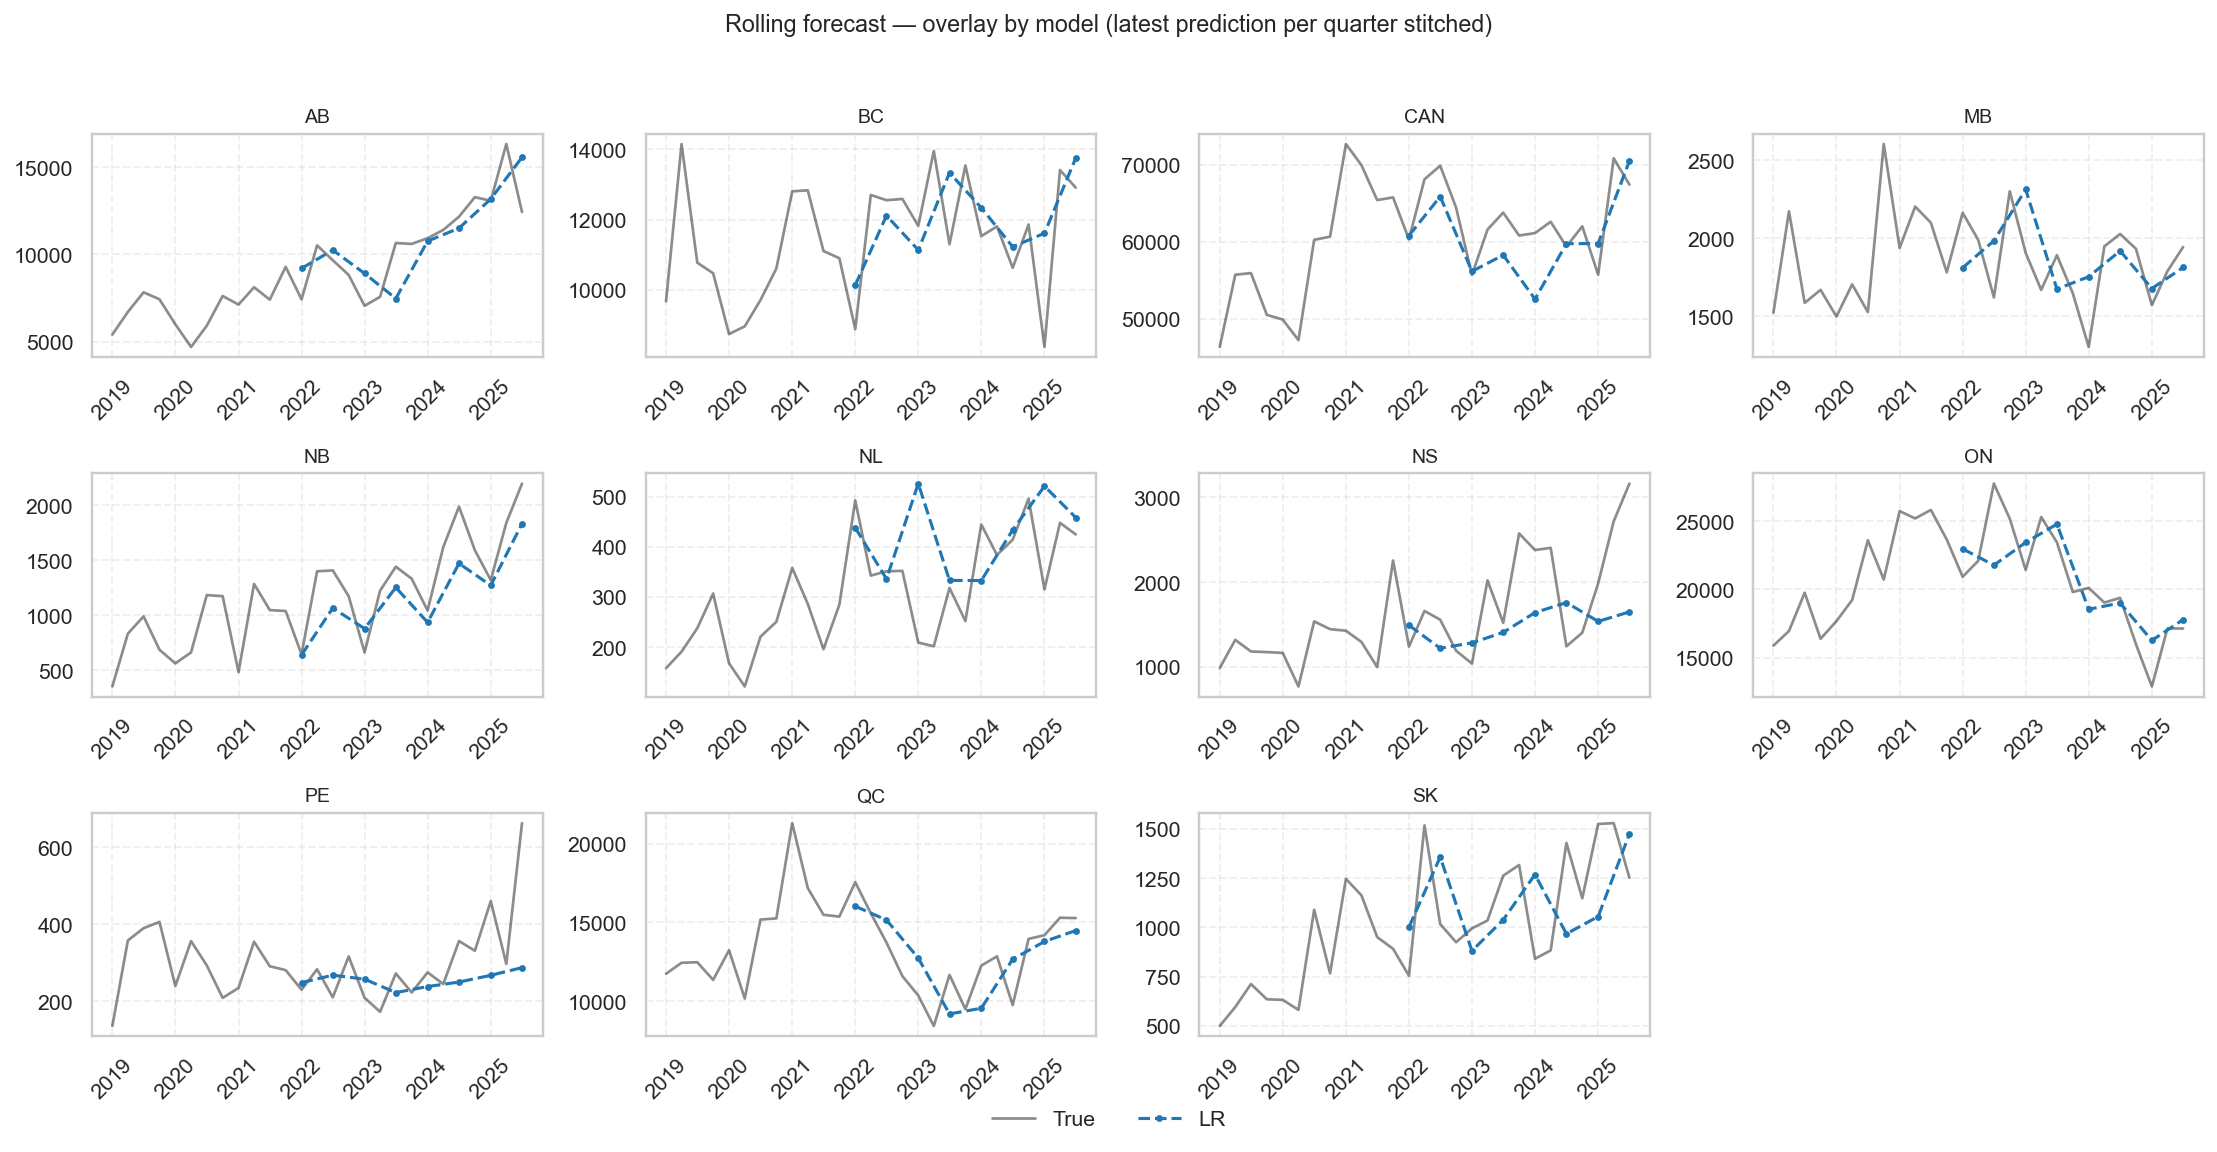

cutoff province model    quarter        y_true        y_pred  \
4   2021-10-01       ab   etr 2022-01-01   7420.750000   9661.334375   
59  2022-04-01       ab   etr 2022-07-01   9667.833333   9089.288333   
114 2022-10-01       ab   etr 2023-01-01   7050.416667   8862.312500   
169 2023-04-01       ab   etr 2023-07-01  10658.250000   7875.479375   
224 2023-10-01       ab   etr 2024-01-01  10934.833333   9110.309167   
279 2024-04-01       ab   etr 2024-07-01  12168.916667  11650.572708   
334 2024-10-01       ab   etr 2025-01-01  13085.666667  12836.341458   
389 2025-04-01       ab   etr 2025-07-01  12439.125000  11614.136667   
0   2021-10-01       ab    lr 2022-01-01   7420.750000   9201.846400   
55  2022-04-01       ab    lr 2022-07-01   9667.833333  10252.059538   

     MASE_denom  cut_rank  
4    801.173442         0  
59   828.096667         1  
114  828.433727         2  
169  833.354005         3  
224  844.601145         4  
279  837.944236         5  
334  839.462963         6  
389  852.466545         7  
0    801.173442         0  
55   828.096667         1

In [92]:
# ===============================
# Cell 11 — Run: load, prep, select features by choice, tune/load cache, evaluate, visualize
# ===============================
# 1) Load + frame
raw = pd.read_csv(DATA_PATH)
model_df = build_model_frame(raw)

# Ensure datetime dtype
model_df["quarter"] = pd.to_datetime(model_df["quarter"], errors="coerce")

# 2) Choose features by prediction choice
H, feat_cols = features_for_choice(PREDICTION_CHOICE)
print(f"Mode: {PREDICTION_CHOICE} | Horizon H={H}")
print("Features:", feat_cols)

# 3) Remove rows with NaNs in chosen features/target
safe_df = model_df.dropna(subset=feat_cols + ["y"]).copy()

# 4) Holdout split
train, test = chrono_split(safe_df, cutoff=CUTOFF_DATE)
print(f"Train: {train['quarter'].min().date()} → {train['quarter'].max().date()} | "
      f"Test: {test['quarter'].min().date()} → {test['quarter'].max().date()}")

# 5) Tune or load cached best params (cache key depends on choice)
best_params = load_or_tune_best_params(
    train_df=train,
    features=feat_cols,
    models_to_run=ALL_MODELS,
    prediction_choice=PREDICTION_CHOICE,
    n_iter=8,     # increase if you want more thorough tuning
    fh=H,
    initial=None,
)

# 6) Final fit on TRAIN + predict on TEST
preds_holdout = fit_predict_holdout_per_province(
    train_df=train, test_df=test, features=feat_cols,
    models_to_run=ALL_MODELS, best_params=best_params,
    prediction_choice=PREDICTION_CHOICE, target="dwelling_starts"
)

# 7) Summary tables
print("\n=== Holdout averages across provinces (tuned) ===")
g_model, g_pm = summarize_metrics_table(preds_holdout)

naive_holdout = add_naive_to_holdout(
    safe_df=safe_df, train_df=train, test_df=test,
    horizon=H, target_col="dwelling_starts"
)

preds_holdout_with_naive = pd.concat([preds_holdout, naive_holdout], ignore_index=True)


# 8) Train–Test overlay (multiple models per province)
plot_holdout_overlay(preds_holdout_with_naive, ALL_MODELS)

plot_holdout_overlay(preds_holdout_with_naive, ['lr'])

# 9) Rolling evolution — latest cutoff overlay
preds_roll = rolling_evolution_overlay(
    df_all=safe_df,
    features=feat_cols,
    best_params=best_params,
    models_to_plot=ALL_MODELS,
    fh=H,
    initial="2012-12-31",
    step=2,                  # speed/coverage trade-off
    last_k_cutoffs=8,
    show_history=False,
    return_df=True,
)

naive_roll = add_naive_to_holdout(
    safe_df=safe_df, train_df=train, test_df=test,
    horizon=H, target_col="dwelling_starts"
)

preds_roll_with_naive = pd.concat([preds_roll, naive_holdout], ignore_index=True)

# 10) Rolling stitched lines (latest per quarter across folds)
if preds_roll is not None:
    d_latest = latest_per_quarter(preds_roll_with_naive)
    rolling_overlay_lines(d_latest, ALL_MODELS)
    
if preds_roll is not None:
    d_latest = latest_per_quarter(preds_roll_with_naive)
    rolling_overlay_lines(d_latest, ['lr'])

# Peek
preds_roll.head(10) if preds_roll is not None else None


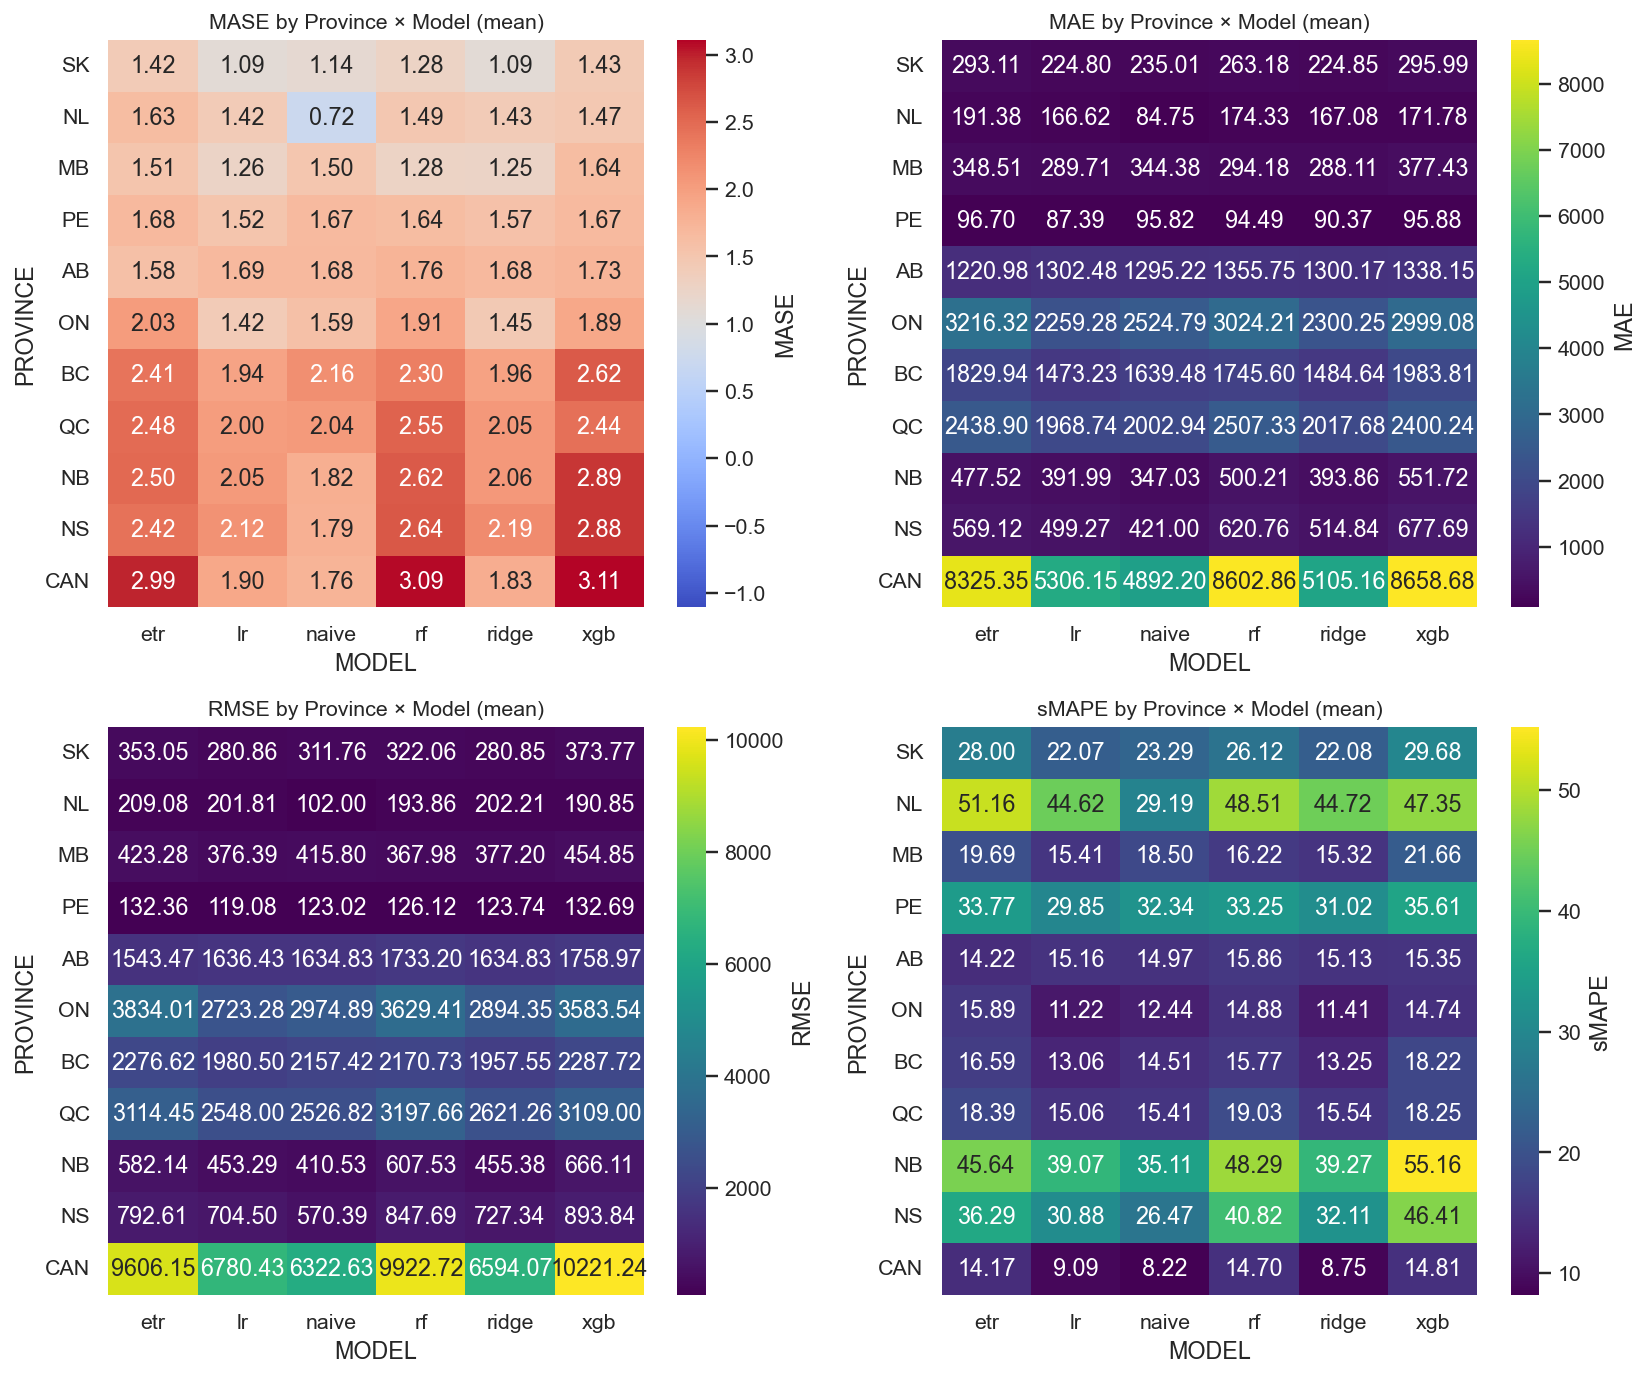

In [93]:
plot_perf_heatmaps_from_preds(
    preds_df=preds_holdout_with_naive,
    metrics=("MASE","MAE","RMSE","sMAPE"),
    center_on_1=("MASE",),
    mase_fallback_to_existing_col=True
)

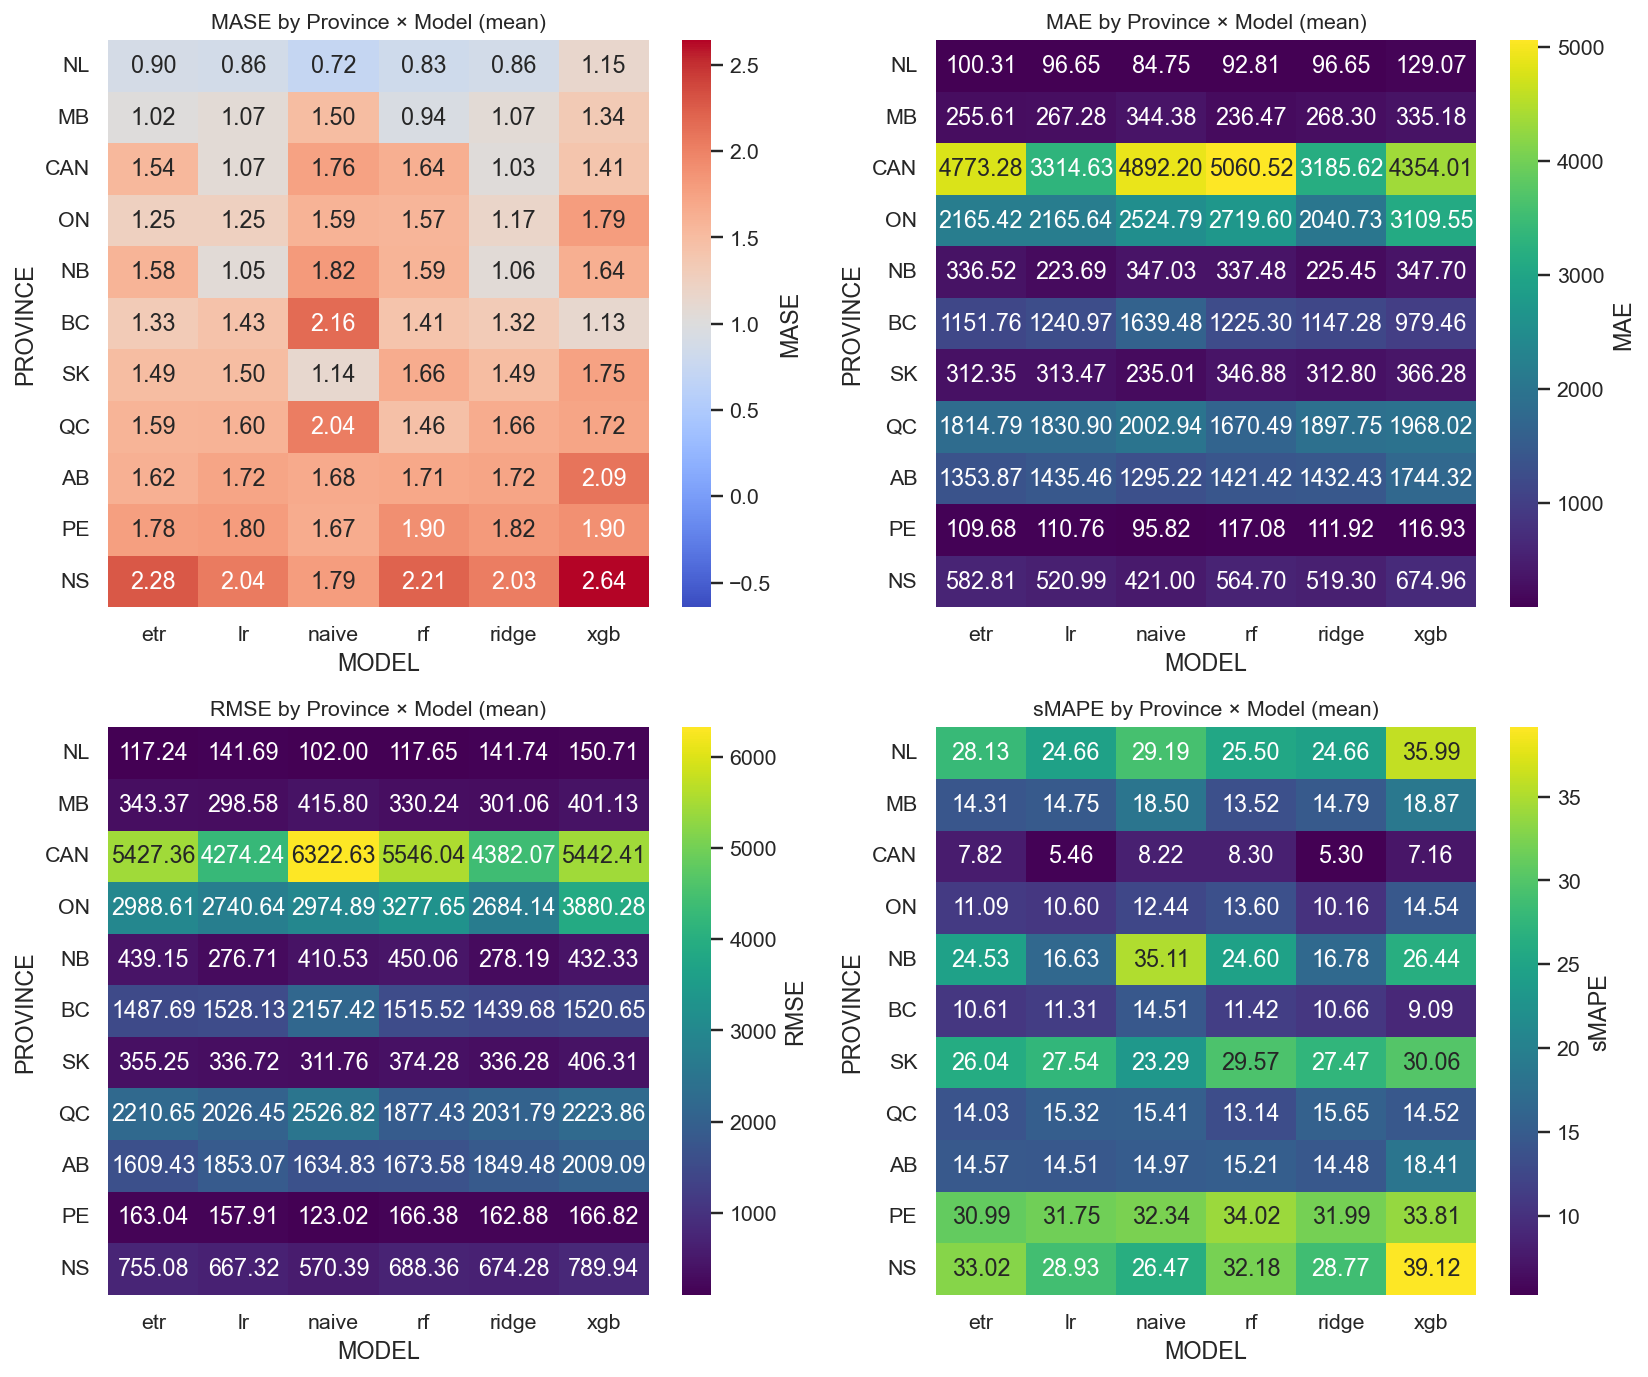

cutoff province model    quarter        y_true        y_pred  \
0 2021-10-01       ab   etr 2022-01-01   7420.750000   9661.334375   
1 2022-04-01       ab   etr 2022-07-01   9667.833333   9089.288333   
2 2022-10-01       ab   etr 2023-01-01   7050.416667   8862.312500   
3 2023-04-01       ab   etr 2023-07-01  10658.250000   7875.479375   
4 2023-10-01       ab   etr 2024-01-01  10934.833333   9110.309167   
5 2024-04-01       ab   etr 2024-07-01  12168.916667  11650.572708   
6 2024-10-01       ab   etr 2025-01-01  13085.666667  12836.341458   
7 2025-04-01       ab   etr 2025-07-01  12439.125000  11614.136667   
8 2021-10-01       ab    lr 2022-01-01   7420.750000   9201.846400   
9 2022-04-01       ab    lr 2022-07-01   9667.833333  10252.059538   

   MASE_denom  cut_rank  MAE  RMSE  sMAPE  MASE  MAPE  
0  801.173442       0.0  NaN   NaN    NaN   NaN   NaN  
1  828.096667       1.0  NaN   NaN    NaN   NaN   NaN  
2  828.433727       2.0  NaN   NaN    NaN   NaN   NaN  
3  833.354005       3.0  NaN   NaN    NaN   NaN   NaN  
4  844.601145       4.0  NaN   NaN    NaN   NaN   NaN  
5  837.944236       5.0  NaN   NaN    NaN   NaN   NaN  
6  839.462963       6.0  NaN   NaN    NaN   NaN   NaN  
7  852.466545       7.0  NaN   NaN    NaN   NaN   NaN  
8  801.173442       0.0  NaN   NaN    NaN   NaN   NaN  
9  828.096667       1.0  NaN   NaN    NaN   NaN   NaN

In [94]:
plot_perf_heatmaps_from_preds(
    preds_df=preds_roll_with_naive,
    metrics=("MASE","MAE","RMSE","sMAPE"),
    center_on_1=("MASE",),
    mase_denom_col="MASE_denom"
)

preds_roll_with_naive.head(10)
